# 二項分布モデルでのP値

* 黒木玄
* 作成: 2025-11-26
* 更新: 2025-12-06
$
\newcommand\op{\operatorname}
$

このファイルは以下の場所で閲覧できます。

* https://github.com/genkuroki/public/blob/main/0055/binomial%20P-values.ipynb
* https://nbviewer.org/github/genkuroki/public/blob/main/0055/binomial%20P-values.ipynb
* https://raw.githubusercontent.com/genkuroki/public/refs/heads/main/0055/binomial%20P-values.pdf
* https://htmlpreview.github.io/?https://github.com/genkuroki/public/blob/main/0055/binomial%20P-values.html

[Google Colab](https://colab.research.google.com/)でも実行できます。

* https://colab.research.google.com/github/genkuroki/public/blob/main/0055/binomial%20P-values.ipynb

<!--
<span style="color:red;font-weight:bold">参照文献の記述がひどく未完成なので取り扱い注意!</span>
-->

In [1]:
# IPAフォントを手動でインストール ⇒ https://moji.or.jp/ipafont/ipa00303/
# このノートブックでは"ipag"フォントを使用する。
haskey(ENV, "COLAB_GPU") && run(`apt-get -y install fonts-ipafont-gothic`)

false

In [2]:
# Google Colabと自分のパソコンの両方で使えるようにするための工夫

haskey(ENV, "COLAB_GPU") && (ENV["JULIA_PKG_PRECOMPILE_AUTO"] = "0")
using Pkg

"""すでにPkg.add済みのパッケージのリスト"""
_packages_added = [sort!(readdir(Sys.STDLIB));
    sort!([info.name for (uuid, info) in Pkg.dependencies() if info.is_direct_dep])]

"""_packages_added内にないパッケージをPkg.addする"""
add_pkg_if_not_added_yet(pkg) = if isnothing(Base.find_package(pkg))
    println(stderr, "# $(pkg).jl is not added yet, so let's add it.")
    Pkg.add(pkg)
end

"""expr::Exprからusing内の`.`を含まないモジュール名を抽出"""
function find_using_pkgs(expr::Expr)
    pkgs = String[]
    function traverse(expr::Expr)
        if expr.head == :using
            for arg in expr.args
                if arg.head == :. && length(arg.args) == 1
                    push!(pkgs, string(arg.args[1]))
                elseif arg.head == :(:) && length(arg.args[1].args) == 1
                    push!(pkgs, string(arg.args[1].args[1]))
                end
            end
        else
            for arg in expr.args arg isa Expr && traverse(arg) end
        end
    end
    traverse(expr)
    pkgs
end

"""必要そうなPkg.addを追加するマクロ"""
macro autoadd(expr)
    pkgs = find_using_pkgs(expr)
    :(add_pkg_if_not_added_yet.($(pkgs)); $expr)
end

@autoadd

<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#二項検定のP値に関する解説の例" data-toc-modified-id="二項検定のP値に関する解説の例-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>二項検定のP値に関する解説の例</a></span><ul class="toc-item"><li><span><a href="#P値の導入" data-toc-modified-id="P値の導入-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>P値の導入</a></span><ul class="toc-item"><li><span><a href="#片側P値の定義" data-toc-modified-id="片側P値の定義-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>片側P値の定義</a></span></li><li><span><a href="#両側P値-(単にP値と呼ぶことが多い)-の定義" data-toc-modified-id="両側P値-(単にP値と呼ぶことが多い)-の定義-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>両側P値 (単にP値と呼ぶことが多い) の定義</a></span></li></ul></li><li><span><a href="#P値の報告の仕方" data-toc-modified-id="P値の報告の仕方-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>P値の報告の仕方</a></span></li><li><span><a href="#認知バイアスに注意せよ！" data-toc-modified-id="認知バイアスに注意せよ！-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>認知バイアスに注意せよ！</a></span><ul class="toc-item"><li><span><a href="#ゼロ主義-(nullism)" data-toc-modified-id="ゼロ主義-(nullism)-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>ゼロ主義 (nullism)</a></span></li><li><span><a href="#二分法への執着-(dichotomania)" data-toc-modified-id="二分法への執着-(dichotomania)-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>二分法への執着 (dichotomania)</a></span></li><li><span><a href="#モデルと現実の混合-(model-reification)" data-toc-modified-id="モデルと現実の混合-(model-reification)-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>モデルと現実の混合 (model reification)</a></span></li></ul></li><li><span><a href="#細かな注意" data-toc-modified-id="細かな注意-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>細かな注意</a></span><ul class="toc-item"><li><span><a href="#「検定仮説」という用語を使う理由" data-toc-modified-id="「検定仮説」という用語を使う理由-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>「検定仮説」という用語を使う理由</a></span></li><li><span><a href="#片側確率の2倍の両側P値の正確な定義と欠点" data-toc-modified-id="片側確率の2倍の両側P値の正確な定義と欠点-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>片側確率の2倍の両側P値の正確な定義と欠点</a></span></li><li><span><a href="#片側P値だけではなく、両側P値を考えたくなる理由" data-toc-modified-id="片側P値だけではなく、両側P値を考えたくなる理由-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>片側P値だけではなく、両側P値を考えたくなる理由</a></span></li><li><span><a href="#尤度とP値の違いに注意せよ" data-toc-modified-id="尤度とP値の違いに注意せよ-1.4.4"><span class="toc-item-num">1.4.4&nbsp;&nbsp;</span>尤度とP値の違いに注意せよ</a></span></li><li><span><a href="#尤度についてさらに補足" data-toc-modified-id="尤度についてさらに補足-1.4.5"><span class="toc-item-num">1.4.5&nbsp;&nbsp;</span>尤度についてさらに補足</a></span></li></ul></li><li><span><a href="#P値の計算の仕方の詳しい説明" data-toc-modified-id="P値の計算の仕方の詳しい説明-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>P値の計算の仕方の詳しい説明</a></span><ul class="toc-item"><li><span><a href="#二項係数の記号法" data-toc-modified-id="二項係数の記号法-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>二項係数の記号法</a></span></li><li><span><a href="#片側P値の計算" data-toc-modified-id="片側P値の計算-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>片側P値の計算</a></span></li><li><span><a href="#両側P値の計算" data-toc-modified-id="両側P値の計算-1.5.3"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span>両側P値の計算</a></span></li></ul></li><li><span><a href="#両側P値の計算練習問題" data-toc-modified-id="両側P値の計算練習問題-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>両側P値の計算練習問題</a></span><ul class="toc-item"><li><span><a href="#二項分布の確率の表の作成" data-toc-modified-id="二項分布の確率の表の作成-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>二項分布の確率の表の作成</a></span></li><li><span><a href="#無作為抽出された患者20人中6人に効いた場合の両側P値" data-toc-modified-id="無作為抽出された患者20人中6人に効いた場合の両側P値-1.6.2"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>無作為抽出された患者20人中6人に効いた場合の両側P値</a></span></li><li><span><a href="#無作為抽出された患者20人中15人に効いた場合の両側P値" data-toc-modified-id="無作為抽出された患者20人中15人に効いた場合の両側P値-1.6.3"><span class="toc-item-num">1.6.3&nbsp;&nbsp;</span>無作為抽出された患者20人中15人に効いた場合の両側P値</a></span></li></ul></li><li><span><a href="#S値(＝意外度)のコイン投げによる定義" data-toc-modified-id="S値(＝意外度)のコイン投げによる定義-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>S値(＝意外度)のコイン投げによる定義</a></span></li><li><span><a href="#P値に関する広く通用する閾値は存在しない" data-toc-modified-id="P値に関する広く通用する閾値は存在しない-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>P値に関する広く通用する閾値は存在しない</a></span></li><li><span><a href="#相性の良さ/悪さ-(compatibility/incompatibility)-という解釈の仕方" data-toc-modified-id="相性の良さ/悪さ-(compatibility/incompatibility)-という解釈の仕方-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>相性の良さ/悪さ (compatibility/incompatibility) という解釈の仕方</a></span></li><li><span><a href="#P値関数と点推定値" data-toc-modified-id="P値関数と点推定値-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>P値関数と点推定値</a></span></li><li><span><a href="#S値関数" data-toc-modified-id="S値関数-1.11"><span class="toc-item-num">1.11&nbsp;&nbsp;</span>S値関数</a></span></li><li><span><a href="#相性区間-＝CI＝信頼区間" data-toc-modified-id="相性区間-＝CI＝信頼区間-1.12"><span class="toc-item-num">1.12&nbsp;&nbsp;</span>相性区間 ＝CI＝信頼区間</a></span></li><li><span><a href="#報告の仕方について" data-toc-modified-id="報告の仕方について-1.13"><span class="toc-item-num">1.13&nbsp;&nbsp;</span>報告の仕方について</a></span></li><li><span><a href="#一般に統計分析は何をやっているとみなされるか" data-toc-modified-id="一般に統計分析は何をやっているとみなされるか-1.14"><span class="toc-item-num">1.14&nbsp;&nbsp;</span>一般に統計分析は何をやっているとみなされるか</a></span></li></ul></li><li><span><a href="#二項検定の様々な種類のP値関数のグラフ" data-toc-modified-id="二項検定の様々な種類のP値関数のグラフ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>二項検定の様々な種類のP値関数のグラフ</a></span></li><li><span><a href="#尤度関数や事後分布とP値関数の比較" data-toc-modified-id="尤度関数や事後分布とP値関数の比較-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>尤度関数や事後分布とP値関数の比較</a></span><ul class="toc-item"><li><span><a href="#データの値が「無作為に選んだ患者-n=20-人中-k=6-人に薬Aが効いた」で、平坦事前分布の場合" data-toc-modified-id="データの値が「無作為に選んだ患者-n=20-人中-k=6-人に薬Aが効いた」で、平坦事前分布の場合-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>データの値が「無作為に選んだ患者 n=20 人中 k=6 人に薬Aが効いた」で、平坦事前分布の場合</a></span></li><li><span><a href="#データの値が「無作為に選んだ患者-n=20-人中-k=6-人に薬Aが効いた」で、偏った事前分布の場合" data-toc-modified-id="データの値が「無作為に選んだ患者-n=20-人中-k=6-人に薬Aが効いた」で、偏った事前分布の場合-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>データの値が「無作為に選んだ患者 n=20 人中 k=6 人に薬Aが効いた」で、偏った事前分布の場合</a></span></li><li><span><a href="#データの値が「無作為に選んだ患者-n=200-人中-k=60-人に薬Aが効いた」で、上と同じ偏った事前分布の場合" data-toc-modified-id="データの値が「無作為に選んだ患者-n=200-人中-k=60-人に薬Aが効いた」で、上と同じ偏った事前分布の場合-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>データの値が「無作為に選んだ患者 n=200 人中 k=60 人に薬Aが効いた」で、上と同じ偏った事前分布の場合</a></span></li><li><span><a href="#比較の結論" data-toc-modified-id="比較の結論-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>比較の結論</a></span></li></ul></li><li><span><a href="#参照文献" data-toc-modified-id="参照文献-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>参照文献</a></span></li><li><span><a href="#動画解説" data-toc-modified-id="動画解説-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>動画解説</a></span></li><li><span><a href="#Wasserman-2014の11.9の例の簡単な紹介" data-toc-modified-id="Wasserman-2014の11.9の例の簡単な紹介-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Wasserman 2014の11.9の例の簡単な紹介</a></span></li></ul></div>

In [3]:
ENV["LINES"], ENV["COLUMNS"] = 200, 200
const mincho = "ipamp"
const gothic = "ipagp"

# Google Colab では6分程度かかる
@autoadd begin
using Distributions
using Plots
end

default(fmt=:png, fontfamily=gothic,
    titlefontsize=12, legendfontsize=12, guidefontsize=12, plot_titlefontsize=12)
default(fontfamily=gothic) # 日本語フォントの利用

In [4]:
"""
    central法による二項分布の両側P値
二項分布binにおける「k以下になる確率の2倍」と「k以上になる確率の2倍」の小さい方の値

このP値からClopper-Pearsonの相性区間(信頼区間)が得られる。
"""
pvalue_central(bin, k) = min(2cdf(bin, k), 2ccdf(bin, k-1))
pvalue_central(n, k, p) = pvalue_central(Binomial(n, p), k)

"""Clopper-Pearsonの相性区間"""
function ci_clopper_pearson(n, k; α = 0.05)
    p_L = k > 0 ? quantile(Beta(k, n-k+1), α/2) : zero(α)
    p_U = k < n ? quantile(Beta(k+1, n-k), 1-α/2) : one(α)
    [p_L, p_U]
end

ci_clopper_pearson

In [5]:
n, k, p = 20, 18, 0.6
bin = Binomial(n, p)
var"one-sided P for n,k,p=20,18,0.6" =
bar(0:k-1, k -> pdf(bin, k); label="", c=1, lc=:match)
bar!(k:n, k -> pdf(bin, k); label="", c=:red, lc=:match)
plot!(xtick=0:n, xlim=(-0.7, n+0.7), ylim=(-0.03, 1.3).*pdf(bin, mode(bin)))
plot!(xguide="その20人中での薬Aが効く患者の仮想的人数 k", yguide="確率")
title!("検定仮説が「薬Aが効く患者の割合は60%」で\
    無作為に20人の患者を選んだ場合の二項確率")
for j in 0:n
    c = j < k ? :black : :red
    annotate!(j, pdf(bin, j)+0.05pdf(bin, mode(bin)), 
        text(string(round(100pdf(bin, j); sigdigits=3))*"%", :left, 90.0, 10, c))
end
annotate!(19, 0.11, text("これらの和\nの0.36%\nが片側P値", gothic, 12, :red))
annotate!(18.8, -0.04, text("データの値\n「18人に効いた」", gothic, 11, :red))
plot!(legend=:topleft, size=(800, 350), 
    bottommargin=8Plots.mm, leftmargin=4Plots.mm);

In [6]:
n, k, p = 20, 18, 0.6
bin = Binomial(n, p)
var"two-sided P for n,k,p=20,18,0.6" =
bar(0:k-1, k -> pdf(bin, k); label="", c=1, lc=:match)
bar!(k:n, k -> pdf(bin, k); label="", c=:red, lc=:match)
plot!(xtick=0:n, xlim=(-0.7, n+0.7), ylim=(-0.03, 1.3).*pdf(bin, mode(bin)))
plot!(xguide="その20人中での薬Aが効く患者の仮想的人数 k", yguide="確率")
title!("検定仮説が「薬Aが効く患者の割合は60%」で\
    無作為に20人の患者を選んだ場合の二項確率")
for j in 0:n
    c = j < k ? :black : :red
    annotate!(j, pdf(bin, j)+0.05pdf(bin, mode(bin)), 
        text(string(round(100pdf(bin, j); sigdigits=3))*"%", :left, 90.0, 10, c))
end
annotate!(19, 0.12, text("これらの和\nの２倍\nの0.72%\nが両側P値", gothic, 12, :red))
annotate!(18.8, -0.04, text("データの値\n「18人に効いた」", gothic, 11, :red))
plot!(legend=:topleft, size=(800, 350), 
    bottommargin=8Plots.mm, leftmargin=4Plots.mm);

## 二項検定のP値に関する解説の例

以下の例は中原治著『基礎から学ぶ統計学』(\[[中原治2022](#中原治2022)\])の「1-5 二項検定」の節の「5⃣ STEP 4: 棄却域と有意水準」以降の説明をP値に関する説明で置き換えることを意識して書かれたものです。経緯については

* https://x.com/genkuroki/status/1993698819541004669?s=20

にある𝕏 (旧twitter)におけるスレッドを参照して下さい。

その本の例題1.1では、薬Bは60%の患者に効果があることが分かっていると仮定されており、薬Aについては無作為に選んだ患者20人中18人に効果があったというデータの値が得られていると仮定されています。以下の説明でもこの設定を使います。

__例題1.1の設定:__

* 薬Bは患者の60%に効くことがわかっている。
* 薬Aについては患者の何%に効くかはわかっていない。
* 「無作為に選んだ患者20人中18人に薬Aに効果があった」というデータの値が得られた。
* 以上の状況で薬Aと薬Bが効く患者の割合を比較したい。

__警告:__ 以下では薬Aを試してみる患者達が患者達全体の集団から理想的な形で無作為に抽出されていると仮定します。これは非現実的な仮定です。現実の研究では、倫理的問題や予算制約など諸々の都合によって、患者達全体ではなく、その一部分の偏った集団からの抽出にならざるを得なくなります。この点は統計学の実践では最重要の問題になります。初学者の段階を脱して、現実の問題に統計学を応用する場合にはこの警告を必ず思い出すようにしてください。
<br><br>

### P値の導入

例題1.1の文脈では、ある確率でその値の __小ささ__ を次のように解釈できるものがあると便利です:

>「無作為に選んだ患者20人中18人に薬Aは効いた」というデータの値が得られたとき、「薬Aが効く患者の割合が薬Bと同じ60%である」と信じている人は確率的にどれだけ意外だと感じるか。

つまり「確率の値の小ささ」を「意外さ」を意味すると解釈するわけです。

以下では、そのために仕える __P値 (P-value)__ という確率の値の構成の仕方について、例題1.1の場合を例に説明します。

#### 片側P値の定義

例題1.1の状況では、「意外さ」の尺度として使える __片側P値 (one-sided P-value)__ が

>「薬Aが効く患者の割合が60%である」という仮定の下で、無作為に選んだ患者20人中18人 __以上__ に薬Aが効く確率

と定義されます。この確率の値(片側P値の値)は0.36%とかなり小さくなります(計算の仕方の詳細は抗うつ)。だから、

>「薬Aが効く患者の割合が薬Bと同じ60%である」と信じている人にとって、「無作為に選んだ患者20人中18人に薬Aが効いた」というデータの値はかなり意外に感じられるだろう

と解釈できます。

このようにP値は「モデルの確率分布でデータの値 __以上に極端な__ 値が生成される確率」として構成されることが多い。

上で定義した片側P値の場合には「データの値 __以上に極端な__ 値が生成される確率」の意味は「データの値の18人以上に効く確率」に設定されている。

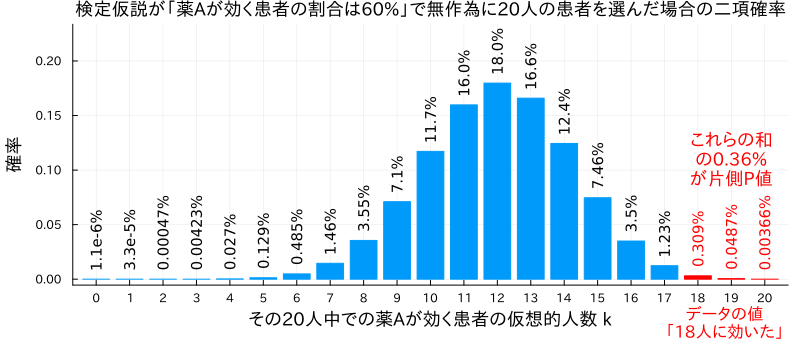

In [7]:
var"one-sided P for n,k,p=20,18,0.6"

#### 両側P値 (単にP値と呼ぶことが多い) の定義

さらに __両側P値 (two-sided P-value)__ が片側P値の2倍で定義されます。この両側P値は、より詳しくは、

>「無作為に選んだ患者20人中18人に薬Aが効いた」というデータの値に関する「薬Aが効く患者の割合が60%である」という検定仮説の両側P値

と呼ばれます。単にP値と言えば両側P値を意味することが多いです。

以上の場合での両側P値は0.72%でやはりかなり小さいので、やはり、

>「薬Aが効く患者の割合が薬Bと同じ60%である」と信じている人にとって、「無作為に選んだ患者20人中18人に薬Aが効いた」というデータの値はかなり意外に感じられるだろう

と解釈できます。

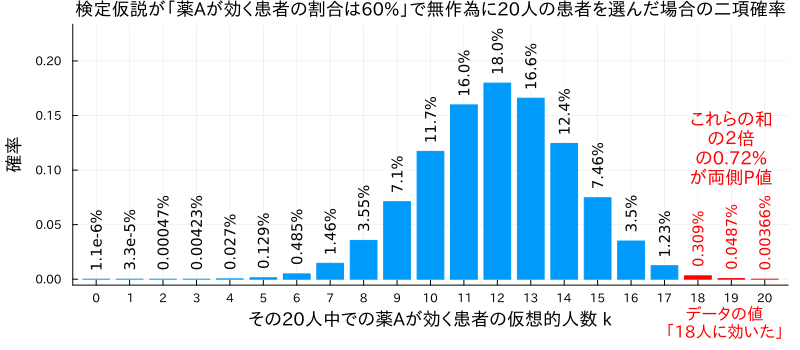

In [8]:
var"two-sided P for n,k,p=20,18,0.6"

一般に

>「無作為に選んだ患者n人中k人に薬Aは効いた」というデータの値に関する「薬Aが効く患者の割合はpである」という検定仮説の両側P値

の小ささは

>「薬Aが効く患者の割合はpである」という検定仮説を信じている人が、「無作為に選んだ患者n人中k人に薬Aは効いた」というデータの値に感じる意外さ

を表しています。

P値は小さければ小さいほど、統計モデル(例えば二項分布)とそのパラメータに関する検定仮説の組み合わせの下でデータの値の意外さが大きいことを意味します。

__警告:__ P値を検定仮説の正しさの尺度だと解釈することは誤りです。

以下では単にP値と言ったら、両側P値を意味するものとします。

### P値の報告の仕方

P値を $P$ と書くとき、$P < 0.05$ のようにP値の具体的な値が不明になるような報告の仕方をしてはいけません。

Ｐ値を報告する場合には $P = 3.2\%$ のように具体的な値がわかるように報告するようにしましょう。ただし、例外的にP値が $P=0.000023=2.3\mathrm{e-}5$ のように非常に小さな値になり、近似計算の精度を超えている場合には $P < 0.0001$ のように報告しても良いでしょう。

$P=0.04205785495554228$ のように無意味に高過ぎる精度でP値を報告してもいけません。複雑な現実における統計分析では、理想的なデータの取得は不可能だったり、統計分析のために採用する統計モデルの妥当性自体が不明だったりするので、高精度なP値の値には意味がないと考えられます。

一般に、統計分析の結果を報告するときには、P値などの統計分析で得られる数値では測ることができないバイアスや不確実性があることを謙虚に認めることが必要になります。

この解説ではP値 (P-value) のPを大文字で書くことにしたのですが、小文字のpと書いても問題ありません。どちらでもよいです。

### 認知バイアスに注意せよ！

Sander Greenland の講演スライド \[[Greenland slide 2022](#Greenland-slide-2022)\] に基いて、統計分析で陥り易い3つの認知バイアス __ゼロ主義 (nullism)__、__二分法への執着 (dichotomania)__、__モデルと現実の混同 (model reification)__ について簡単に解説しておきます。

#### ゼロ主義 (nullism)

以上では、薬Aの効き目を60%の患者に効くことがすでに分かっている薬Bと比較したいという状況を扱ったので、データの値を使ってテストしたい仮説(検定仮説)として「薬Aが効く患者の割合は薬Bと同じ60%である」を採用しました。

このような差がないことを意味する仮説を __ゼロ仮説__ と呼ぶことにします(\[[佐藤俊哉2024](#佐藤俊哉2024)\])。

非常に残念なことに、統計学の伝統には、検定仮説として採用する仮説としてゼロ仮説だけしか考えないという悪習があります。この悪習に基く認知バイアスは __ゼロ主義 (nullism)__ と呼ばれています(\[[Amrhein-Greenland 2022](#Amrhein-Greenland-2022)\],　\[[Greenland slide 2022](#Greenland-slide-2022)\])。

統計学ユーザー達はゼロ主義の認知バイアスを払拭するために、ゼロ仮説単独のP値だけではなく、任意の割合$p$に関する「薬Aが効く患者の割合は$p$である」のP値も計算してみるべきです(パラメータの値にP値を対応させる関数を __P値関数__ と呼びます(後述))。

#### 二分法への執着 (dichotomania)

伝統的なP値の利用法は以下の通り:

>有意水準(significance level)と誤解を招く呼び方をされている慣用的な閾値 $\alpha=0.05$ を設定し、P値が $\alpha$ 未満か否かで「統計的に有意/非有意」もしくは「有意差あり/なし」というこれまた誤解を招く言い方で二値的な判断を行う。

非常に残念なことに、白黒をつけられない場合やつけるべきではない場合にも統計的有意性(statistical significance)によって白黒つけてしまう行為が慣習化されてしまっており、科学研究のプロセスと社会的な科学コミュニケーションを酷く害しています(\[[ASA声明2016](#ASA声明2016)\], \[[Amrhein-Greenland-McShane-2019](#Amrhein-Greenland-McShane-2019)\])。

この認知バイアスは __二分法への執着 (dichotomania)__ と呼ばれています(\[[Amrhein-Greenland-McShane-2019](#Amrhein-Greenland-McShane-2019)\], \[[Greenland-slide 2022](#Greenland-slide-2022)\])。安易な二分法は多くの文献で批判されています(\[[Greenland et al. 2016](#Greenland-et-al-2016)\], \[[Rafi-Greenland 2020](#Rafi-Greenland-2020)\], \[[McShane et al. 2024](#McShane-et-al-2024)\])。

二分法への執着の認知バイアスを払拭するための最も簡単な方法は、「統計的に有意/非有意」「有意差あり/なし」という言い方自体を止めてしまうことです(以上で紹介した文献を参照)。この解説ではそういう立場を全面的に支持しています。

#### モデルと現実の混合 (model reification)

二項分布や正規分布のような理想化された数学的フィクションと複雑な現実を混同してしまう誤りも横行しています。この認知バイアスを __モデルと現実の混同 (model reification)__ と呼びます。

例えば、この解説のように二項分布をモデルとして採用した場合には、現実におけるデータの取得法では無作為抽出のような数学的仮定は理想的には成立していないことに注意する必要があります。

数学的仮定からの逸脱が実践的に問題にならないほど小さいと期待できるならば問題ないのですが、現実には問題になるほど大きく逸脱している場合が多数出て来ます。

データ自体がバイアスを含むことを防げない場合には、統計分析に使用するモデルの側をより複雑なものに変更してバイアスを減らす工夫が必要になります。

データのバイアスを減らすための工夫やデータが含むバイアスをモデル側の工夫によって減らす方法は、統計学のテクニカルな側面の中核部分であり、非常に面白い話題なのです。しかし、これは初学者向けの解説なので、そうした話題はこの解説の範囲外になります。

しかし、1936年のリテラリ―ダイジェスト誌による米大統領選挙の結果予測の失敗の件に関する2つの論文 \[[Lusinchi 2012](#Lusinchi-2012)\] \[[動画解説](#video-Lusinchi-2012)\]、\[[Lohr-Brick 2017](#Lohr-Brick-2017)\] \[[動画解説](#video-Lohr-Brick-2017)\] を順番にチェックすると非常に良い教訓が得られることは紹介しておきたいと思います。

さらに、Andrew Gelman and Aki Vehtari, Active Statitics \[[Gelman-Vehtari 2024](#Gelman-Vehtari-2024)\] という素晴らしい本が出版されており、この本では様々な教訓が得られる沢山の事例が紹介されています。

### 細かな注意

以下の注意は最初に読むときにはとばしても構いません。

#### 「検定仮説」という用語を使う理由

伝統的な用語法では検定仮説は __帰無仮説 (nullhypothesis)__ とも呼ばれています。

しかし、日本語的に帰無仮説という用語の意味が分かり難い。さらに、英単語のnullがzeroという意味を持つせいで、null hypothesis は差がないことを意味するゼロ仮説であるかのように誤解されがちです。だから、この解説では帰無仮説という用語を避けて、検定仮説という用語を採用しました。

初期のNeymanが検定仮説(test hypothesis)という用語を使っていたので、検定仮説も十分に由緒正しい用語だと考えられます。「検定」は英語のtestの翻訳で「検定仮説」は「データの値とモデルを使ってテストする仮説」というような意味になります。

しかし、世の中には伝統的な分かり難い言い方の方を好む人達もいるので、そういう人達の相手をする場合には「帰無仮説」という言い方を使う方が親切な場合もあると思われます。
<br><br><br>

#### 片側確率の2倍の両側P値の正確な定義と欠点

「無作為に選んだ $n$ 人中 $k$ 人に薬が効いた」というデータの値が得られたときの、片側確率の2倍で定義された「薬が効く患者の割合は$p$である」という仮説の両側P値の正確な定義は

>薬が効く確率が $p$ であるという仮定の下で、無作為に選んだ $n$ 人中 $k$ 人以上に効く確率の2倍と無作為に選んだ $n$ 人中 $k$ 人以下に効く確率の小さい方の値

です。このように定義された両側P値の欠点は

* 無用に値が大きくなり過ぎるという性質を持つ。
* $1$ より大きくなることがある。

P値は確率だとみなしたい値なので0以上1以下になって欲しいのですが、上の定義だと1より大きくなってしまう場合が出て来てしまいます。その欠点をなくすために、

>薬が効く確率が $p$ であるという仮定の下で、無作為に選んだ $n$ 人中 $k$ 人以上に効く確率の2倍と無作為に選んだ $n$ 人中 $k$ 人以下に効く確率と __1__ の中での最小値

と定義することも多いです。

#### 片側P値だけではなく、両側P値を考えたくなる理由

薬Aが無作為に選んだ患者20人中60%の12人よりもずっと大きな人数(例えば18人)に効果があった場合だけではなく、その反対側のずっと小さな人数(例えば5人)にしか効果がない場合にも、薬Aが効く患者の割合が60%だと信じている人にとっては意外だと感じられるでしょう。

このことから、無作為に選んだ患者20人中60%の12人からデータの値以上に離れる確率の小ささで、「薬Aが効く患者の割合は60%」という仮説を信じている人から見たデータの値の意外さを評価するという考え方も十分にあり得ることが分かります。

そのような考え方で定義されたP値が両側P値です。

このノートの解説では、シンプルに反対側の確率はもとの片側確率に等しいだろうという大雑把な想定のもとで、片側確率の2倍で両側P値を定義しました。

モデルの確率分布が左右非対称な場合には他にも無数の選択肢(このノートの解説で採用した方法central法以外にも、minimum likelihood法、スコア法、Wald法など)があるのですが、そういう問題については統計学の技術的側面についてもっと詳しくなってから考えれば十分です。

#### 尤度とP値の違いに注意せよ

上の方では片側P値を「効果がある患者の割合が60%であると仮定したとき、無作為に選んだ患者20人中18人 __以上__ に効果がある確率」と定義し、両側P値をその2倍で定義しました。

読者の中には太字になっている「以上」を削除して、「効果がある患者の割合が60%であると仮定したとき、無作為に選んだ患者20人中18人に効果がある確率」を考えたくなる人がいると思います。その人は鋭い！

「以上」の語を取り去ってできる確率は __尤度(ゆうど)__ と呼ばれており、統計分析における最も基本的かつ重要な量になっています。尤度とP値を混同しないように注意して下さい。

#### 尤度についてさらに補足

「効果がある患者の割合が60%である」という仮説を信じている人が「無作為に選んだ患者20人中18人に効果があった」というデータの値を見たときには、シンプルに「効果がある患者の割合が60%であると仮定したとき、無作為に選んだ患者20人中18人に効果がある確率」(=尤度(ゆうど))を __モデルとデータの値を比較するための尺度__ として使いたくなると思います。

そのアイデアは極めて正しく、尤度は __モデルがどれだけデータの値に適合しているか__ を表していると解釈でき、 __最尤法 (maximum likelihood method)__ の基礎になります。

__警告:__ 尤度(ゆうど)は英語で likelihood と言います。しかし、モデルがデータに過剰適合している場合にモデルはもっともらしくなくなるので、尤度をもっともらしさの尺度だと解釈することは誤りになります。教科書の多くがこの点において間違っているので注意してください。この誤りはP値を検定仮説の正しさの尺度とみなす誤りに類似しています。

最尤法は nuisance parameters がある場合のP値関数の構成における最も基本的なテクニックになっています。このあたりのことも初学者向けの解説では触れることは難しいです。

そして尤度をさらに有効利用するための __ベイズ統計__ の方法に発展する考え方にもなっています。非常に残念なのですが、この解説ではほとんど触れないことにします。

しかし、後で述べるP値関数の概念と使い方を理解できれば、ベイズ統計について勉強したときにも「事後分布はP値関数とほぼ同じ使い方をすればよい」という形で応用が効くので心配する必要はないです。
<br><br><br>

### P値の計算の仕方の詳しい説明

#### 二項係数の記号法

以下では二項係数を

$$
\binom{n}{k} = {}_nC_k = \frac{n!}{k!(n-k)!}
$$

と表すことにします。例えば, $0!=1$ に注意すると、

$$
\begin{aligned}
&
\binom{20}{20} = \frac{20!}{20!0!} = \frac{20!}{20!} = 1,
\\ &
\binom{20}{19} = \frac{20!}{19!1!}
=\frac{20\cdot 19\cdot 18\cdots 2\cdot 1}{19\cdot 18\cdots 2\cdot 1\times 1}
= 20,
\\ &
\binom{20}{18} = \frac{20!}{18!2!}
=\frac{20\cdot 19\cdot 18\cdot 17\cdots 2\cdot 1}{18\cdot 17\cdots 2\cdot 1\times 2}
= 190.
\end{aligned}
$$

${}_nC_k$ は高校数学では標準的な記号ですが、専門的な文献では $\binom{n}{k}$ の方がよく使われているように思われるので主に $\binom{n}{k}$ を使います。どちらを使うかは好みの問題でしかないので、$\binom{n}{k}$ という書き方が嫌いな人は ${}_nC_k$ と書いても構いません。

#### 片側P値の計算

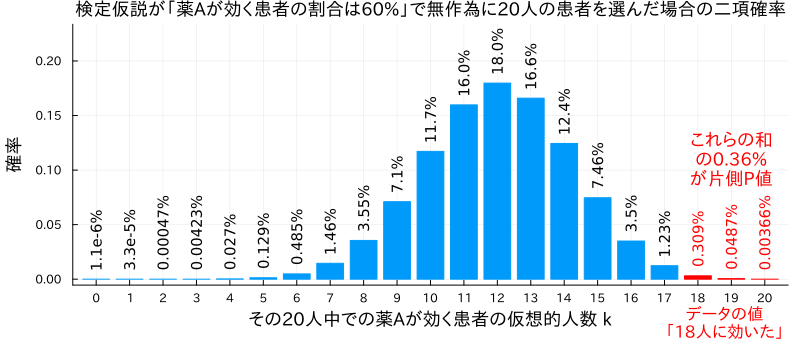

In [9]:
var"one-sided P for n,k,p=20,18,0.6"

片側P値と呼ばれる

>効果がある患者の割合が60%だと仮定したとき、無作為に選んだ患者20人中18人 __以上__ に効果がある確率

は次のように計算される。

* (20人中$k$人に効果がある確率) $= \binom{20}{k}0.6^{k}(1-0.6)^{20-k}$

なので、関数電卓その他を使って計算すると、

* (20人中20人に効果がある確率) $= \binom{20}{20}0.6^{20}(1-0.6)^0 = 0.6^{20} \approx 3.6561584400629733\mathrm{e-}5$
* (20人中19人に効果がある確率) $= \binom{20}{19}0.6^{19}(1-0.6)^1 = 20\cdot 0.6^{19}\cdot 0.4 \approx 0.00048748779200839646$
* (20人中18人に効果がある確率) $= \binom{20}{18}0.6^{18}(1-0.6)^2 = 190\cdot 0.6^{18}\cdot 0.4^2 \approx 0.003087422682719845$

ここで $3.6561584400629733\mathrm{e-}5$ は $3.6561584400629733\times 10^{-5}$ を意味する。

上の3つの値の和を計算することによって次を得る:

* (片側P値)＝(20人中18人以上に効果がある確率) $\approx 0.003611472059128871$

#### 両側P値の計算

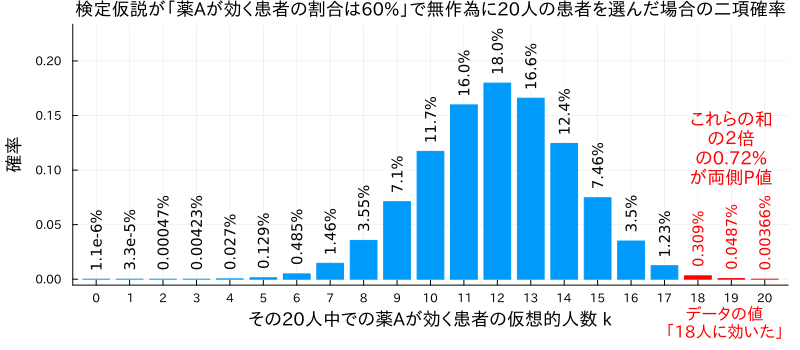

In [10]:
var"two-sided P for n,k,p=20,18,0.6"

両側P値は片側P値0.00361の2倍なので、

* (両側P値) $= 0.007222944118257742$

以上によって片側P値は約0.36%で両側P値は約0.72%になることが分かった.

In [11]:
@show binomial(20, 20)
@show binomial(20, 19)
@show binomial(20, 18)
@show p20 = 1 * 0.6^20 * 0.4^0
@show p19 = 20 * 0.6^19 * 0.4^1
@show p18 = 190 * 0.6^18 * 0.4^2
@show pval_one_sided = p20 + p19 + p18
@show pval_both_sided = 2pval_one_sided;

binomial(20, 20) = 1
binomial(20, 19) = 20
binomial(20, 18) = 190
p20 = 1 * 0.6 ^ 20 * 0.4 ^ 0 = 3.6561584400629733e-5
p19 = 20 * 0.6 ^ 19 * 0.4 ^ 1 = 0.00048748779200839646
p18 = 190 * 0.6 ^ 18 * 0.4 ^ 2 = 0.003087422682719845
pval_one_sided = p20 + p19 + p18 = 0.003611472059128871
pval_both_sided = 2pval_one_sided = 0.007222944118257742


### 両側P値の計算練習問題

#### 二項分布の確率の表の作成

__問題:__ 「薬Aが効く患者の割合は60%である」という仮定の下で「薬Aは無作為抽出された20人中$k$人に効いた」というデータの値が得られる確率$P(k)$を0以上20以下のすべての整数$k$について求め、確率の数表を作成せよ。<br><br><br>

__解答例:__ 二項分布の確率 $P(k) = \binom{20}{k} 0.6^k 0.4^{20-k}$ を $k=0,1,2,\ldots,20$ について求めればよい. その結果は次のようになる:

|k|P(k)||k|P(k)|
|---:|:---|---|---:|:---|
|0 | 1.09951e-8|　|12 | 0.179706|
|1 | 3.29853e-7||13 | 0.165882|
|2 | 4.70041e-6||14 | 0.124412|
|3 | 0.0000423037||15 | 0.074647|
|4 | 0.000269686||16 | 0.0349908|
|5 | 0.00129449||17 | 0.0123497|
|6 | 0.00485435||18 | 0.00308742|
|7 | 0.0145631||19 | 0.000487488|
|8 | 0.0354974||20 | 0.0000365616|
|9 | 0.0709949||||
|10 | 0.117142||||
|11 | 0.159738||||

ただし、1.09951e-8は1.09951×10⁻⁸を意味する。以上の結果はWolframAlphaに

```mathematica
Table[k, {k, 0, 20}], Table[Binomial[20, k]*0.6^k*0.4^(20-k), {k, 0, 20}]
```

と入力することによって得られる([WolframAlphaで実行](https://www.wolframalpha.com/input?i=Table%5Bk%2C+%7Bk%2C+0%2C+20%7D%5D%2C+Table%5BBinomial%5B20%2C+k%5D*0.6%5Ek*0.4%5E%2820-k%29%2C+%7Bk%2C+0%2C+20%7D%5D+&lang=ja)).

<img width=70% src="https://raw.githubusercontent.com/genkuroki/public/refs/heads/main/0055/WolframAlpha%EF%BC%BFBinomial_20_0.6.png">

In [12]:
Any[0:11 pdf.(Binomial(20, 0.6), 0:11) 12:23 pdf.(Binomial(20, 0.6), 12:23)]

12×4 Matrix{Any}:
  0  1.09951e-8   12  0.179706
  1  3.29853e-7   13  0.165882
  2  4.70041e-6   14  0.124412
  3  4.23037e-5   15  0.074647
  4  0.000269686  16  0.0349908
  5  0.00129449   17  0.0123497
  6  0.00485435   18  0.00308742
  7  0.0145631    19  0.000487488
  8  0.0354974    20  3.65616e-5
  9  0.0709949    21  0.0
 10  0.117142     22  0.0
 11  0.159738     23  0.0

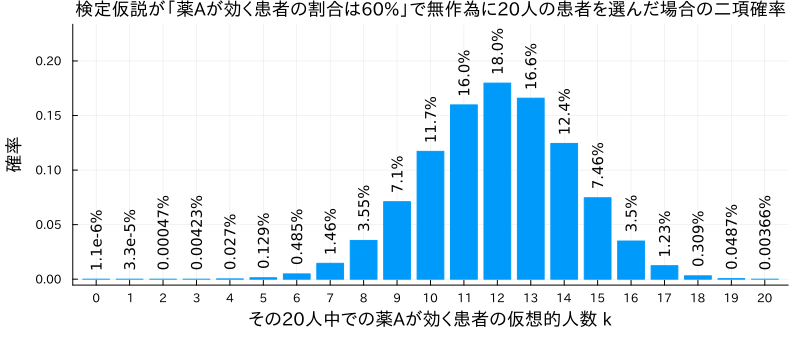

In [13]:
n, p = 20, 0.6
bin = Binomial(n, p)
bar(0:n, k -> pdf(bin, k); label="", c=1, lc=:match)
plot!(xtick=0:n, xlim=(-0.7, n+0.7), ylim=(-0.03, 1.3).*pdf(bin, mode(bin)))
plot!(xguide="その20人中での薬Aが効く患者の仮想的人数 k", yguide="確率")
title!("検定仮説が「薬Aが効く患者の割合は60%」で\
    無作為に20人の患者を選んだ場合の二項確率")
for j in 0:n
    annotate!(j, pdf(bin, j)+0.05pdf(bin, mode(bin)), 
        text(string(round(100pdf(bin, j); sigdigits=3))*"%", :left, 90.0, 10))
end
plot!(legend=:topleft, size=(800, 350), 
    bottommargin=8Plots.mm, leftmargin=4Plots.mm)

#### 無作為抽出された患者20人中6人に効いた場合の両側P値

__問題:__ 「薬Aは無作為に抽出された患者20人中6人に効いた」というデータの値に関する「薬Aが効く患者の割合は60%である」という仮説の両側P値を求めよ。ただし、その両側P値は片側確率の2倍で定義されたものとする。その計算で上の問題で作成した確率の数表を用いて良い。

__解答例:__ 求めるべき両側P値は、「薬Aが効く患者の割合は60%である」という仮定の下で「薬Aが効いた人数は無作為抽出された20人中6人以下であった」となる確率の2倍である。ゆえに、求めたい両側P値は、上の問題で求めた確率$P(k)$を$k=0,1,2,3,4,5,6$について足し合わせて2倍すれば求まる。

In [14]:
(1.09951e-8 +
3.29853e-7 + 
4.70041e-6 + 
0.0000423037 + 
0.000269686 + 
0.00129449 + 
0.00485435) * 2

0.012931741916200001

「薬Aは無作為に抽出された患者20人中6人に効いた」というデータの値に関する「薬Aが効く患者の割合は60%である」という仮説の両側P値は約1.3%である。

この値はかなり小さめなので、「薬Aが効く患者の割合は60%である」という仮説の下で「薬Aは無作為に抽出された患者20人中6人に効いた」というデータの値はかなり意外だとみなされる。
<br><br><br>

In [15]:
pvalue_central(Binomial(20, 0.6), 6)

0.01293175070407002

この計算結果 0.01293175070407002 は上の計算結果 0.012931741916200001 と微小に異なるが、上の計算では有効桁が少ない計算になっているせいで精度が少し低いだけで、どちらも誤りではない。

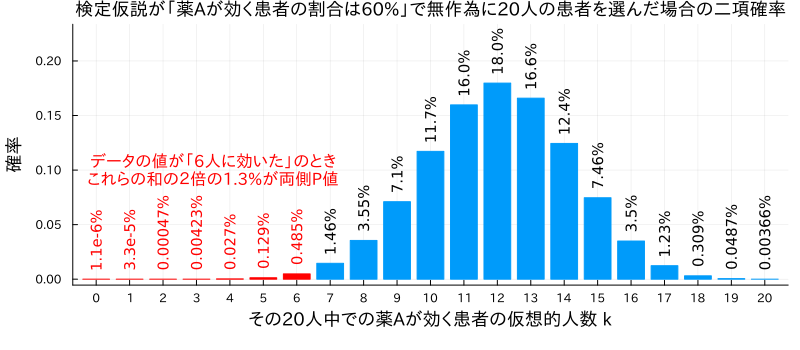

In [16]:
n, k, p = 20, 6, 0.6
bin = Binomial(n, p)
bar(k+1:n, k -> pdf(bin, k); label="", c=1, lc=:match)
bar!(0:k, k -> pdf(bin, k); label="", c=:red, lc=:match)
plot!(xtick=0:n, xlim=(-0.7, n+0.7), ylim=(-0.03, 1.3).*pdf(bin, mode(bin)))
plot!(xguide="その20人中での薬Aが効く患者の仮想的人数 k", yguide="確率")
title!("検定仮説が「薬Aが効く患者の割合は60%」で\
    無作為に20人の患者を選んだ場合の二項確率")
for j in 0:n
    c = j > k ? :black : :red
    annotate!(j, pdf(bin, j)+0.05pdf(bin, mode(bin)), 
        text(string(round(100pdf(bin, j); sigdigits=3))*"%", :left, 90.0, 10, c))
end
annotate!(3.5, 0.1, 
    text("データの値が「6人に効いた」のとき\n\
        これらの和の２倍の1.3%が両側P値", gothic, 11, :red))
plot!(legend=:topleft, size=(800, 350),
    bottommargin=8Plots.mm, leftmargin=4Plots.mm)

#### 無作為抽出された患者20人中15人に効いた場合の両側P値

__問題:__ 「薬Aは無作為に抽出された患者20人中15人に効いた」というデータの値に関する「薬Aが効く患者の割合は60%である」という仮説の両側P値を求めよ。ただし、その両側P値は片側確率の2倍で定義されたものとする。その計算で上の問題で作成した確率の数表を用いて良い。

__解答例:__ $P(k)$ の $k=15,16,17,18,19,20$ に関する和の2倍を計算すれば良い.

In [17]:
(0.074647 +
0.0349908 +
0.0123497 +
0.00308742 +
0.000487488 +
0.0000365616) * 2

0.25119793920000005

「薬Aは無作為に抽出された患者20人中15人に効いた」というデータの値に関する「薬Aが効く患者の割合は60%である」という仮説の両側P値は約25%である。

この25%のP値はかなり大きな値なので、「薬Aが効く患者の割合は60%である」という仮説の下で「薬Aは無作為に抽出された患者20人中15人に効いた」というデータの値をほとんど意外ではないと考えられる。

In [18]:
pvalue_central(Binomial(20, 0.6), 15)

0.2511979454460751

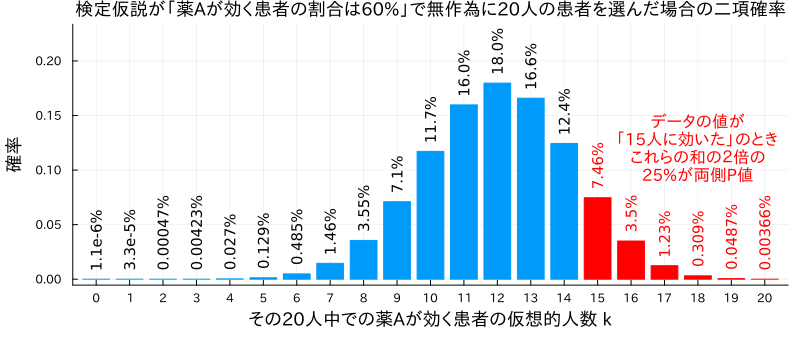

In [19]:
n, k, p = 20, 15, 0.6
bin = Binomial(n, p)
bar(0:k-1, k -> pdf(bin, k); label="", c=1, lc=:match)
bar!(k:n, k -> pdf(bin, k); label="", c=:red, lc=:match)
plot!(xtick=0:n, xlim=(-0.7, n+0.7), ylim=(-0.03, 1.3).*pdf(bin, mode(bin)))
plot!(xguide="その20人中での薬Aが効く患者の仮想的人数 k", yguide="確率")
title!("検定仮説が「薬Aが効く患者の割合は60%」で\
    無作為に20人の患者を選んだ場合の二項確率")
for j in 0:n
    c = j < k ? :black : :red
    annotate!(j, pdf(bin, j)+0.05pdf(bin, mode(bin)), 
        text(string(round(100pdf(bin, j); sigdigits=3))*"%", :left, 90.0, 10, c))
end
annotate!(18, 0.12, 
    text("データの値が\n「15人に効いた」のとき\n\
        これらの和の２倍の\n25%が両側P値", gothic, 11, :red))
plot!(legend=:topleft, size=(800, 350),
    bottommargin=8Plots.mm, leftmargin=4Plots.mm)

### S値(＝意外度)のコイン投げによる定義

以下では、「無作為に選んだ患者$n$人中$k$人に薬Aが効いた」というデータの値に関する「薬Aが効く患者の割合は$p$である」という仮説の(両側)P値を以下では $P$ と書くことにします。

P値 $P$ の値が小ささは、「薬Aが効く患者の割合は$p$である」という仮説を信じている人が「無作為に選んだ患者$n$人中$k$人に薬Aが効いた」というデータの値をどれだけ意外だと感じるかを表すのでした。

__意外さの程度は偏りがないコイン投げに例えると分かり易くなります。__

例えば、偏りのないコイン投げで4回続けて表が出る確率は $6.25\%\approx 6\%$ である。だから、$P\approx 6\%$ であることは、

>「薬Aが効く患者の割合は$p$である」と信じている人が「無作為に選んだ患者$n$人中$k$人に薬Aが効いた」というデータの値について感じる意外さ

が

>偏りがないコイン投げで __4__ 回続けて表が出たのと同じ程度の意外さ

だとみなされることを意味していると考えられます。

同様に $P\approx 3\%$ であることは、上と同じ意味での意外さが

>偏りがないコイン投げで __5__ 回続けて表が出たのと同じ程度の意外さ

だとみなされることを意味していると考えられます。

便宜的にコイン投げの回数として非整数も許されることにすれば、$P\approx 5\%$ であることは、上と同じ意味での意外さが

>偏りがないコイン投げで __4.3__ 回続けて表が出たのと同じ程度の意外さ

だとみなされることを意味していると考えられます。実際、

$$
(1/2)^{4.3} \approx 0.05.
$$

より正確には $(1/2)^{4.3} \approx 0.050765774772264724$.

P値 $P$ に対して以上のようにして決まる偏りがないコイン投げで連続して表が出る回数を $S$ は次のように得られます:

$$
(1/2)^S = P \quad\text{すなわち}\quad S = -\log_2 P.
$$

この $S$ はP値 $P$ に対応する __S値 (意外度、surprisal value)__ と呼ばれています(\[[Rafi-Greenland 2020](#Rafi-Greenland-2020)\])。

S値は曖昧な「P値の小ささ」=「意外さ」という言い方で語られる概念の定量化だと考えられます。つまり、S値の大きさは「意外さ」の大きさそのものだと解釈されます。

P値とS値の対応は以下の通りです。

<!--
|P値|S値(意外度)|
|:---|---:|
|100%|0|
|50%|1|
|25%|2|
|約12%|約3|
|約6%|約4|
|約3%|約5|
|約1.5%|約6|
|約0.8%|約7|
|約0.4%|約8|
|約0.2%|約9|
|約0.1%|約10|
-->

|S値＝意外度|0|1|2|3|4|5|6|7|8|9|10|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|P値|100%|50%|約25%|約12%|約6%|約3%|約1.5%|約0.8%|約0.4%|約0.2%|約0.1%|

情報理論的にS値の単位は __ビット__ だと考えらます。例えば、P値が6%程度になった場合には、S値は約4ビットになるので、

>データの値によってモデルと検定仮説の組み合わせの否定について4ビット程度の情報が得られた。

のように考えることになります。

P値の違いの大きさの違いは、対応するS値の側で何ビット違うかを見ると誤解し難くなります。

例えば、$6\%$ と $3\%$ のP値はそれぞれ約 $4$ と $5$ のS値に対応し、1ビットの違いしかありません。

P値については伝統的に $5\%$ の閾値が採用されることが多く、$P < 5\%$ であるか否かによって正反対の結論を出す悪しき慣習があるのですが、$6\%$ と $3\%$ のP値はS値で見たら1ビットの違いしかありません。

$P < 5\%$ であるか否かによって正反対の結論を出すことの不合理さも情報量を意味するS値について理解すれば分かります。

### P値に関する広く通用する閾値は存在しない

$P < 5\%$ であるか否かによる「有意差あり/なし」の二分法に強く執着している人達は、P値に閾値をどうしても設けたいと感じるかもしれません。

しかし、仮に閾値の設定が有効な道具として機能するとしても、ケースバイケースで適切な閾値は異なると考えられます。

検定仮説が諸々の理由で非常に確からしい場合には、その否定のためのP値の閾値は非常に小さくすることが妥当だと考えられます。逆に検定仮説が非常に疑わしい場合にはその否定のためのP値の閾値は10%のような大きめの値にしても十分に合理的になることがあり得ます。

さらに統計分析の結果を用いた意思判断においても、場合ごとに許容できるリスクの大きさと種類は異なります。

以上のような諸々の事情をすべて無視して慣用的な閾値を機械的に採用して押し通そうとすることは不合理な行為だと考えられます。

つまり、誰にでもP値に関する閾値を設ける権利はあるが、5%や1%のような慣用的な閾値を機械的に使うことは不合理であるということです。あなたが閾値を設定した場合にはその責任をあなたが負う必要が出て来る。

統計分析の結果を参考にしながら現実における意思決定を行う主体(例えば臨床医や政策決定責任者など)と統計分析を行うあなたが異なる人物であるならば、閾値の設定は意思決定を行う人にまかせて、意思決定者に責任を取ってもらうのが良いとも考えられます。

実際にそれが正しい場合にあなたは、データの取得法の詳細と有力なモデル(仮説の集まり)の概略とそれらの関係の定量化(P値や点推定や区間推定はその典型例)を意思決定の現場にいる人達にとって分かり易い形式で報告すれば良いでしょう(より詳しくは \[[McShane et al. 2024](#McShane-et-al-2024)\] のガイドラインを参照)。

### 相性の良さ/悪さ (compatibility/incompatibility) という解釈の仕方

「無作為に選んだ患者 $n$ 人中 $k$ 人に薬Aが効いた」というデータの値に関する「薬Aが効く患者の割合は $p$ である」という仮説の(両側)P値 $P$ の小ささとそれに対応するS値 $S=-\log_2 P$ は

>「薬Aが効く患者の割合は $p$ である」という仮説を信じている人が「無作為に選んだ患者 $n$ 人中 $k$ 人に薬Aが効いた」というデータの値に感じる意外度

という意味を持っているのでした。これと同じ意味で、P値の小ささ(＝S値の大きさ)を

>二項分布モデルとそのパラメータに関する「薬Aが効く患者の割合は $p$ である」という検定仮説と「無作為に選んだ患者 $n$ 人中 $k$ 人に薬Aが効いた」というデータの値の __相性の悪さ (incompatibility)__ の尺度

と解釈することにします。これは大小関係を逆転させると、P値の大きさ(＝S値の小ささ)は

>二項分布モデルとそのパラメータに関する「薬Aが効く患者の割合は $p$ である」という検定仮説と「無作為に選んだ患者 $n$ 人中 $k$ 人に薬Aが効いた」というデータの値の __相性の良さ (compatibility)__ の尺度

と解釈されるということを意味しています。

以上の「相性の良さ/悪さ」という言い方も便利なのでこれから使って行くことにします。

__Compatibility (相性の良さ)は最重要キーワード:__ "compatibility" (相性の良さ)は "significance" (有意性)や "confidence" (信頼)のような伝統的だがミスリーディングな用語の置き換え先として再有力視されている単語です
(\[[ASA声明2016](#ASA声明2016)\], 
\[[Greenland et al. 2016](#Greenland-et-al-2016)\], 
\[[Gelman-Greenland 2019](#Gelman-Greenland-2019)\], 
\[[Amrhein-Greenland-McShane 2019](#Amrhein-Greenland-McShane-2019)\], 
\[[Rafi-Greenland 2020](#Rafi-Greenland-2020)\], 
\[[Amrhein-Greenland 2022](#Amrhein-Greenland-2022)\], 
\[[Greenland-slide 2022](#Greenland-slide-2022)\], 
\[[McShane et al. 2024](#McShane-et-al-2024)\])

### P値関数と点推定値

「無作為に選んだ患者 $n$ 人中 $k$ 人に薬Aが効いた」というデータの値に関する「薬Aが効く患者の割合は $p$ である」という仮説の(両側)P値 $P$ は $k,n,p$ の関数なので、それを

>$\op{pvalue}(k|n,p) =$ ($k,n,p$ に関する両側P値)

と書くことにします。

データの値 $k,n$ が与えられたとき, P値 $\op{pvalue}(k|n,p)$ はパラメータ $p$ だけの関数になる。そのときパラメータ $p$ の値にP値 $\op{pvalue}(k|n,p)$ を対応させる関数

> $p \mapsto \op{pvalue}(k|n,p)$

は __P値関数 (P-value function)__ と呼ばれています。日本語の文献では例えば
\[[ロスマンの疫学2013](#ロスマンの疫学2013)\], 
\[[佐藤俊哉2024](#佐藤俊哉2024)\]
にP値関数の説明があります。

例題1.1の状況では、検定仮説が「薬Aが効く患者の割合は $p=0.6$ である」に固定されていました。パラメータ $p$ の仮説値を $0.6$ に固定せずに動かしながらP値を計算して、P値関数のグラフを描けば、パラメータ $p$ のすべての仮説値と「無作為に選んだ患者 $n$ 人中 $k$ 人に薬Aが効いた」というデータの値の相性の良さ(compatibility)の様子が分かることになります。

しかし、P値関数のグラフを得るためには、コンピュータでグラフを描くスキルが必要になります。以下では、この解説の筆者がコンピュータで作成したP値関数のグラフの例を示しましょう。

「無作為に選んだ患者 $n=20$ 人中 $k=6$ 人に薬Aが効いた」というデータに対応するP値関数のグラフを描きましょう。

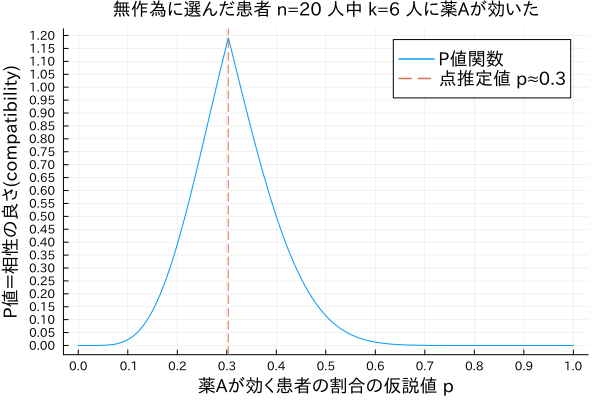

In [20]:
n, k = 20, 6
var"P for n,k=20,6" =
plot(p -> pvalue_central(Binomial(n, p), k), 0, 1; label="P値関数")
plot!(xtick=0:0.1:1, ytick=0:0.05:1.5, yguide="P値＝相性の良さ(compatibility)")
title!("無作為に選んだ患者 n=$n 人中 k=$k 人に薬Aが効いた")
plot!(xguide="薬Aが効く患者の割合の仮説値 p")
vline!([0.303]; label="点推定値 p≈0.3", ls=:dash)

このP値の大きさを見れば、薬Aが効く患者の割合のすべての仮説値 $p$ と「無作為に選んだ患者 $n=20$ 人中 $k=6$ 人に薬Aが効いた」というデータの値の相性の良さが分かります。

例えば、上のP値関数の最大値は $p\approx 0.3$ で与えられるので、

>「無作為に選んだ患者 $n=20$ 人中 $k=6$ 人に薬Aが効いた」というデータの値と最も相性が良い薬Aが効く患者の割合の仮説値は $p\approx 0.3$ である

ことが分かります。このようにP値関数を最大化する $p$ の値は(P値関数から得られる)パラメータ $p$ の __点推定値 (point estimate)__ と呼ばれます。

点推定値 $p\approx 0.3$ から $p$ の値が離れれば離れるほど対応するP値は小さくなり、 $p$ の値とデータの値の相性はどんどん悪くなります。

例えば、「薬Aが効く患者の割合は $p=0.05$ である」や「薬Aが効く患者の割合は $p=0.65$ である」という検定仮説は、「無作為に選んだ患者 $n=20$ 人中 $k=6$ 人に薬Aが効いた」というデータの値と相性がかなり悪いことが上のグラフから分かります。

### S値関数

P値関数のグラフの欠点はその値が $0$ に近い所の様子が見難いことです。P値関数の代わりに同様に定義されたS値関数

$$
p \mapsto -\log_2 \op{pvalue}(k|n, p)
$$

のグラフを描くとP値が $0$ に近い所の様子もよく見えるようになります。

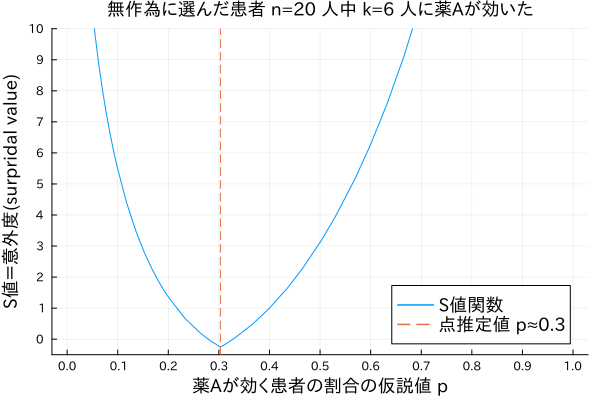

In [21]:
n, k = 20, 6
var"S for n,k=20,6" =
plot(p -> -log(2, pvalue_central(Binomial(n, p), k)), 0, 1; label="S値関数")
plot!(ylim=(-0.5, 10), legend=:bottomright)
plot!(xtick=0:0.1:1, ytick=0:10, yguide="S値＝意外度(surpridal value)")
title!("無作為に選んだ患者 n=$n 人中 k=$k 人に薬Aが効いた")
plot!(xguide="薬Aが効く患者の割合の仮説値 p")
vline!([0.303]; label="点推定値 p≈0.3", ls=:dash)

意外さが大きいことと相性が悪いことは同じ意味であり、S値で表される意外さは偏りのないコイン投げで何回続けて表が出たかを意味しているのでした。

偏りのないコイン投げで5回以上連続して表が出たときに「意外度が非常に大きい」＝「相性が非常に悪い」と便宜的に言うことにすると、$p$ が $0.107$ 以下の場合と $0.564$ 以上の場合に「意外度が非常に大きい」＝「相性が非常に悪い」ということになります。(このとき、区間 $[0.107, 0.564]$ は相性水準$\approx 3\%$の相性区間＝信頼水準$\approx 97\%$ の信頼区間になっている。相性区間(＝信頼区間)の定義については次節を参照せよ。)

ただし、ここで考えているのは「無作為に選んだ患者 $n=20$ 人中 $k=6$ 人に薬Aが効いた」というデータの値と「薬Aが効く患者の割合は $p$ である」という仮説の相性の悪さです。

α = 0.5 ^ 5 = 0.03125
1 - α = 0.96875
ci = ci_clopper_pearson(n, k; α) = [0.10726583473679588, 0.564099648860263]


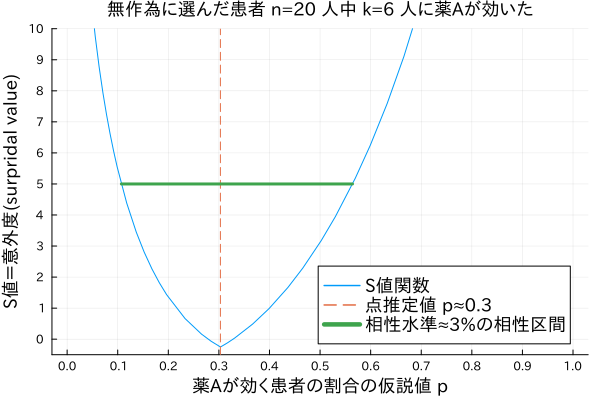

In [22]:
@show α = 0.5^5
@show 1 - α
@show ci = ci_clopper_pearson(n, k; α)

plot(var"S for n,k=20,6")
plot!(ci, fill(-log(2, α), 2); label="相性水準≈3%の相性区間", lw=3)

### 相性区間 ＝CI＝信頼区間

前節でP値関数から点推定値がP値関数を最大化するパラメータ $p$ の値として得られることを説明しました。

パラメータ $p$ の区間推定もP値関数から得られます。

そのためにはP値に関する閾値 $\alpha$ を用意して、$\op{pvalue}(k|n,p) \ge \alpha$ か否かで、パラメータ $p$ の値はデータの値 $n,k$ と相性が良い/悪いとみなすことにします。

伝統的な用語法で閾値 $\alpha$ は有意水準と呼ばれ、$1-\alpha$ は信頼水準(信頼度、信頼係数)と呼ばれています。しかし、それらの伝統的用語法はP値がモデルとパラメータの値に関する仮説の組み合わせとデータの値の相性の良さ(compatibility)の尺度であるという見方と整合的ではないので、$\alpha$ を __相性水準 (compatibility level)__ と呼ぶことにします。

相性水準と呼ぶことにした閾値 $\alpha$ によってデータの値と相性が良いとみなされるパラメータ $p$ の値全体の集合をパラメータ $p$ の __相性区間 (compatibility interval)__ と呼ぶことにします。すなわち、相性区間を $\op{ci}(k|n,\alpha)$ と書くことにすると、

>$\op{ci}(k|n,\alpha)= \{\, p \mid \op{pvalue}(k|n,p)\ge\alpha\,\}$.

一般にP値関数から相性区間(＝信頼区間)はこのようにして定義されます。

伝統的な用語法でこれは __信頼水準__ $1-\alpha$ の __信頼区間__ (もしくは $100(1-\alpha)\%$ __信頼区間__) と呼ばれています。信頼区間は英語では confidence interval と言うので、相性区間も信頼区間も英語で略すとどちらも同じ __CI__ になります。

> 相性区間 ＝ (compatibility interval) ＝ CI ＝ (confidence interval) ＝ 信頼区間

我々が現在扱っているP値関数から得られる相性区間は __Clopper-Pearsonの信頼区間__ (\[[Clopper-Pearson 1934](#Clopper-Pearson-1934)\])と呼ばれる非常に有名な信頼区間と同じものになります。以下ではそれを __Clopper-Pearsonの相性区間__ と呼ぶことにします。

__区間の呼び方に関する注意:__ 2025年現在、compatibility interval (相性区間)という用語はある程度以上のレベルの研究者達にはよく知られていますが、広く普及しているとは言えません。まだ十分に普及していない用語を使いたくない人は、confidence interval (信頼区間)という伝統的な用語を使い続けても構いません。しかし、"confidence" という英単語と「信頼」という日本語の持つ語感が原因で、「95%信頼区間には95%という高い信頼度で真の値が含まれている」と安易に信じても良いかのような誤解が蔓延しています。例えば、統計モデルの妥当性を保証できない場合には、そのように信じることは誤りになります。だから、confidence interval や信頼区間という用語を使う場合には、自分自身と報告の読者が蔓延している誤解に陥らないように十分な注意を払うべきです。

__Clopper-Pearsonの相性区間について:__ Clopper-Pearsonの相性区間にはコンピュータでの効率的な計算に適した明示公式が存在し、その公式を使って実装すると極めて簡単にかつ効率的に計算できます。

ただし、その事実を理解するためには「二項分布とベータ分布の累積分布関数間の関係」や「ベータ分布の累積分布関数が正則化不完全ベータ関数と呼ばれる有名な特殊関数にちょうどなっており、その逆関数の分位点関数もコンピュータで効率的に計算できること」などを学ぶ必要があります。数学的な事柄にも興味がある人は勉強してみると数学とコンピュータでの数値計算について沢山の教養が身に付くことでしょう。

この解説ではその点に深入りせずに、次の非常にシンプルなコードでClopper-Pearsonの相性区間を計算できることを注意するにとどめておきます。

```julia
using Distributions
function ci_clopper_pearson(n, k; α = 0.05)
    p_L = k > 0 ? quantile(Beta(k, n-k+1), α/2) : zero(α)
    p_U = k < n ? quantile(Beta(k+1, n-k), 1-α/2) : one(α)
    [p_L, p_U]
end
```

このコードを用いて、「無作為に選んだ患者 n=20 人中 k=6 人に薬Aが効いた」というデータの値が得られたときの、相性水準 $5\%$ のClopper-Pearsonの相性区間(＝信頼水準 $95\%$ のClopper-Pearson信頼区間)を求めてみましょう。

In [23]:
@show ci_clopper_pearson(20, 6; α = 0.05);

ci_clopper_pearson(20, 6; α = 0.05) = [0.11893159040572766, 0.5427891822762891]


「無作為に選んだ患者 n=20 人中 k=6 人に薬Aが効いた」というデータの値が得られたときの、相性水準 $5\%$ の相性区間(＝信頼水準 $95\%$ のClopper-Pearson信頼区間)はおおよそ $[0.119, 0.543]$ になることが分かりました。

相性水準 $5\%$ の相性区間は、P値に関する $5\%$ 以上という条件によって、「無作為に選んだ患者 $n=20$ 人中 $k=6$ 人に薬Aが効いた」というデータの値と相性が良いとみなされた「薬Aが効く患者の割合の仮説値 $p$」全体の集合になっています。

相性水準 $5\%$ の相性区間はP値関数のグラフを高さ $5\%$ で切断する線分に等しい。次のグラフを参照せよ。

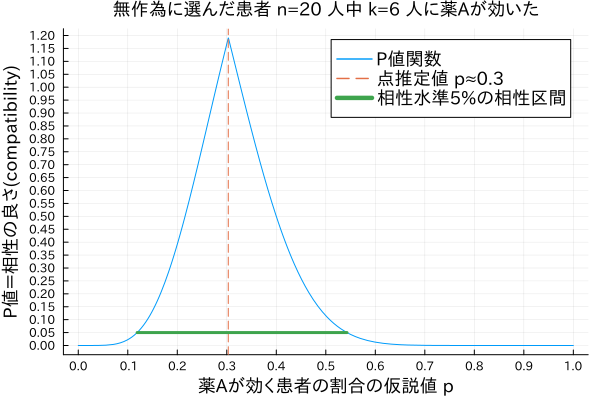

In [24]:
n, k, α = 20, 6, 0.05
ci = ci_clopper_pearson(n, k; α);
plot(var"P for n,k=20,6")
plot!(ci, fill(α, 2); label="相性水準5%の相性区間", lw=3)

このように、P値(より正確にはP値関数)の概念から、点推定値と区間推定の両方が得られる。

S値のグラフにも相性区間を描きこむと次のようになる。相性水準 $5\%$ の相性区間は、S値関数のグラフを高さ $-\log_2 0.05 \approx 4.3$ で切断する線分になる。

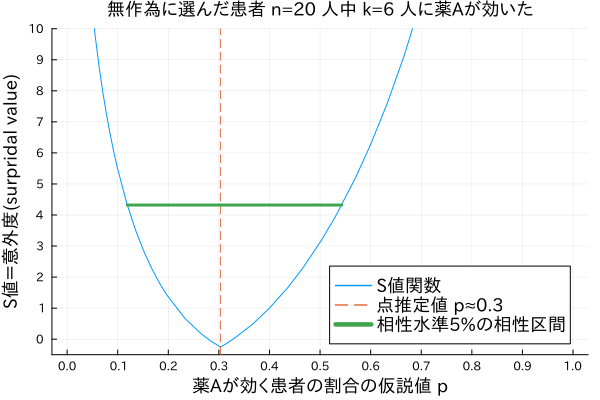

In [25]:
n, k = 20, 6
plot(var"S for n,k=20,6")
plot!(ci, fill(-log(2, α), 2); label="相性水準5%の相性区間", lw=3)

### 報告の仕方について

P値関数やS値関数のグラフは、各検定仮説のP値の情報だけではなく、点推定値と区間推定値の情報も含みます。だから、原理的にはP値関数のグラフを報告に載せれば特定の検定仮説のP値や点推定値や区間推定値を報告する必要はないと考えられます。

しかし、報告の読者がグラフから数値を読みとる手間も省くために、重要だと考えられる検定仮説のP値と点推定値と区間推定値も報告に載せた方が良いでしょう。

統計学の利用者達の間には「有意差あり/なし」と報告したがる伝統的な悪習があるのですが、それを真似する必要はありません。英語の報告では significant の語の使用を控えることは現代的には良いスタイルだということになります。P値の具体的な値を報告していれば、読者の各々が自分の目的に適切な閾値を設定して二分法的な判断を自分でできます。

「有意差あり(P<0.05)」と「有意差なし(P≥0.05)」のように報告には書くべきではありません。

報告を書く側は、主にP値に注目したりせずに、あらゆる情報を考慮に入れて暫定的な結論を述べるべきです。

統計学の利用者達の間には「差はゼロ」や「効果ゼロ」を意味する特殊な検定仮説(それらを __ゼロ仮説__ と呼ぶ \[[佐藤俊哉2024](#佐藤俊哉2024)\])のP値のみを報告する悪しき伝統があります。この悪習にも従う必要はありません。

その悪習は上で説明したようにP値が推定の道具としても使えること(点推定値も区間推定値もP値関数から得られる)を見逃す原因にもなっています。

その悪習から離脱するために、「効果はゼロ」を意味するゼロ仮説のP値だけではなく、「事前に予想していた効果の大きさ」または「それまでの定説の値」の $a$ について「効果は $a$ である」という検定仮説のP値も計算して報告するのは良いスタイルです。

より詳しいガイドラインが論文 \[[McShane et al. 2024](#McShane-et-al-2024)\] ([動画解説1](#video-McShane-et-al-2024-1)、[統計分析の報告に関するガイドラインの日本語版](https://gist.github.com/genkuroki/a7fa24c7b446b3eb267b03b1dc7959c1))にあります。

### 一般に統計分析は何をやっているとみなされるか

現代ではコンピュータにデータの値を入力するだけで統計分析の結果を出力してくれる便利な統計ソフトが普及しています。統計ソフトのユーザーは統計ソフトが出力してくれる統計分析の結果が

>モデル(仮説の集まり)とデータの値の間の関係を定量的に記述した結果

に過ぎないことに常に注意する必要があります。P値、点推定値、区間推定値、ベイズ統計での事後分布とその要約などはすべて

>モデル(仮説の集まり)とデータの値の間の関係を定量的に記述した結果

に過ぎません。だから、統計ソフトが出力結果を利用する場合には、

* どのように取得したデータの値をモデルと比較したか？
* どのようなモデル(仮説の集まり)とデータの値を比較したか？
* モデル(仮説の集まり)とデータの値のどのような関係を定量化したか？

の3つを理解しておく必要があります。これは実はかなり厳しい要請で、この3つのどれについても十分に理解せずに統計ソフトを使っている人達も結構いるように思われます。この解説の読者はそうならないようにして欲しいと思います。

## 二項検定の様々な種類のP値関数のグラフ

このノートブックのずっと上の方で以下の4種類のP値関数を定義している。

* Clopper-Pearsonの相性区間(\[[Clopper-Pearson 1934](#Clopper-Pearson-1934)\])を与える片側確率の2倍版のP値関数 (central法)
* Sterneの相性区間(\[[Sterne 1954](#Sterne-1954)\])を与えるP値関数 (minlike法)
* Wilsonのスコア相性区間(\[[Wilson 1927](#Wilson-1927)\])を与える二項分布の正規分布近似を使うP値関数 (スコア法)
* Waldの相性区間を与えるP値関数 (Wald法 \[[Wald 1939](#Wald-1939)\])

それぞれ以下のような特徴を持ち、それらは互いに異なる利点と欠点を持っています。

* __central法:__ P値関数は左右非対称で部分的に値が1より大きくなり、ベータ分布の累積分布関数(正則化不完全ベータ関数)を用いた明示公式を持つ。片側P値と整合的。αエラー率が確実にα以下になるが、P値が無駄に大きくなり過ぎる傾向があり、これに対応するClopper-Pearsonの相性区間の幅も無駄に広くなり過ぎる傾向がある(つまり過剰に保守的(conservative)である)。これに対応するClopper-Pearsonの相性区間はベータ分布の分位点関数(正則化不完全ベータ関数の逆関数)を用いた効率的な明示公式を持つ。
* __minlike法:__ P値関数は左右非対称な不連続関数になり、効率的な明示公式がないので計算が面倒でかつ、離散分布特有の数値計算特有の事情について注意深く実装する必要がある。αエラー率が確実にα以下になるが、central法と違って過剰な保守性を持たない。対応するSterne相性区間は、計算が面倒なだけではなく、1つの区間にならずに複数の区間に分かれる場合が出て来る。
* __スコア法:__ P値関数は左右非対称で計算は易しい。αエラー率がαでよく近似されるが、αエラー率がαより少し大きくなる場合も出て来る。これに対応するWilsonのスコア相性区間の計算では二次方程式を解く必要がある。
* __Wald法:__ P値関数は左右対称(対称であるべきではない)で計算は易しい。$0$ または $1$ に近いパラメータ値 $p$ でのP値の誤差が大きくなり易い。これに対応するWaldの相性区間の計算も易しい。

論文 \[[Agresti-Coull 1998](#Agresti-Coull-1998)\] による数値実験ではWilsonのスコア相性区間が性能的に優れているという結果が得られいます。その論文は計算が易しいWaldの相性区間のシンプルな補正によって得られる __Agresti-Coull区間 (Agresti-Coull interval)__ と現在呼ばれている区間によって、性能的に優れているWilsonのスコア相性区間をよく近似できることを示したことで非常に有名です。

central法のP値関数の実装はこのノートブックのずっと上の方にあります。

minlike法、スコア法、Wald法によるP値関数およびAgresti-Coull区間の実装例を以下で示しておきます。ただし、[Sterneの相性区間の実装例](https://github.com/genkuroki/public/blob/main/0047/coverage%20prob.ipynb)と[Agresti-Coull区間を与えるP値関数の実装例](https://github.com/genkuroki/public/blob/main/0053/Agresti-Coull%20P-value%20function.ipynb)は別のノートブックにある。

In [26]:
x ⪅ y = x < y || x ≈ y
x ⪆ y = x > y || x ≈ y

"""
    minimum likelihood法による二項分布の両側P値
このP値からSterneの相性区間(信頼区間)が得られる。

実装コード中の `⪅` を `≤` で置き換えると、
数学的に pdf(bin, i) = pdf(bin, k)) (i≠k) であっても、
浮動小数点計算では pdf(bin, i) > pdf(bin, k)) になって、
足されるべき値が足されなくなってしまう場合が生じるのでまずい。
離散分布をコンピューターで扱うときにはこの点に常に注意せよ。
"""
function pvalue_minlike(bin, k)
    supp = support(bin)
    sum(pdf(bin, i) for i in supp if pdf(bin, i) ⪅ pdf(bin, k))
end
pvalue_minlike(n, k, p) = pvalue_minlike(Binomial(n, p), k)

"""
Sterneの相性区間の数学的な定義は

>ci\\_minlike(n, k, α) = { p | pvalue\\_minlike(n, k, p) ≥ α}.

これを実装するには pvalue\\_minlike(n, k, p) = α となる p 達を求める必要がある。
Sterneの相性区間はここでは実装せず。
"""
function ci_minlike end

ci_minlike

In [27]:
@doc pvalue_minlike

```julia
minimum likelihood法による二項分布の両側P値
```

このP値からSterneの相性区間(信頼区間)が得られる。

実装コード中の `⪅` を `≤` で置き換えると、 数学的に pdf(bin, i) = pdf(bin, k)) (i≠k) であっても、 浮動小数点計算では pdf(bin, i) > pdf(bin, k)) になって、 足されるべき値が足されなくなってしまう場合が生じるのでまずい。 離散分布をコンピューターで扱うときにはこの点に常に注意せよ。


In [28]:
@doc ci_minlike

Sterneの相性区間の数学的な定義は

> ci_minlike(n, k, α) = { p | pvalue_minlike(n, k, p) ≥ α}.


これを実装するには pvalue_minlike(n, k, p) = α となる p 達を求める必要がある。 Sterneの相性区間はここでは実装せず。


In [29]:
"""
    score法による二項分布の両側P値
このP値は二項分布の正規分布近似で定義された両側P値と同じ。

このP値はWilsonのスコア相性区間(信頼区間)を与える。
"""
function pvalue_score(bin, k)
    (; n, p) = bin
    phat = k/n
    se = sqrt(p * (1 - p) / n)
    z = (phat - p) / se
    2ccdf(Normal(), abs(z))
end
pvalue_score(n, k, p) = pvalue_score(Binomial(n, p), k)

"""
    Wilsonのスコア相性区間
ある二次方程式を解くことで実装できる。
"""
function ci_score(n, k; α = 0.05)
    phat = k/n
    z = quantile(Normal(), 1-α/2)
    a, b, c = 1+z^2/n, phat+z^2/(2n), phat^2
    # ap² - 2bp + c = 0 を解く.
    sqrtD = √(b^2 - a*c)
    p_L = (b - sqrtD)/a
    p_U = (b + sqrtD)/a
    [p_L, p_U]
end

ci_score

In [30]:
"""
    Wald法による二項分布の両側P値
このP値も二項分布の正規分布近似で定義された両側P値だが、
データ \$n, k\$ から推定する必要がない \$\\hat{p}=k/n\$ の標準偏差
を推定してしまっているので、score法の両側P値よりも精度が低い。

このP値は教科書によく書いてある母比率に関するWaldの相性区間(信頼区間)を与える。
"""
function pvalue_wald(bin, k)
    (; n, p) = bin
    phat = k/n
    sehat = sqrt(phat * (1 - phat) / n)
    z = (phat - p) / sehat
    2ccdf(Normal(), abs(z))
end
pvalue_wald(n, k, p) = pvalue_wald(Binomial(n, p), k)

"""
    Waldの相性区間
非常に簡単に実装できる。
"""
function ci_wald(n, k; α = 0.05)
    phat = k/n
    sehat = √(phat*(1-phat)/n)
    z = quantile(Normal(), 1-α/2)
    p_L = phat - z*sehat
    p_U = phat + z*sehat
    [p_L, p_U]
end

ci_wald

In [31]:
```
Agresti-Coull区間を与えるP値関数は三次方程式を解けば実装できるが、
ここでは実装しない。
```
function pvalue_agresti_coull end

```
    Agresti-Coull区間
Waldの信用区間のシンプルな補正によって、Wilsonのスコア信頼区間を近似。
```
function ci_agresti_coull(n, k; α = 0.05)
    z = cquantile(Normal(), α/2)
    k̃, ñ = k + z^2/2, n + z^2
    ci_wald(k̃, ñ, α)
end

ci_agresti_coull (generic function with 1 method)

「無作為に選んだ患者 n=20 人中 k=6 人に薬Aが効いた」というデータの値に関するこれらのP値関数達のグラフを見てみよう。

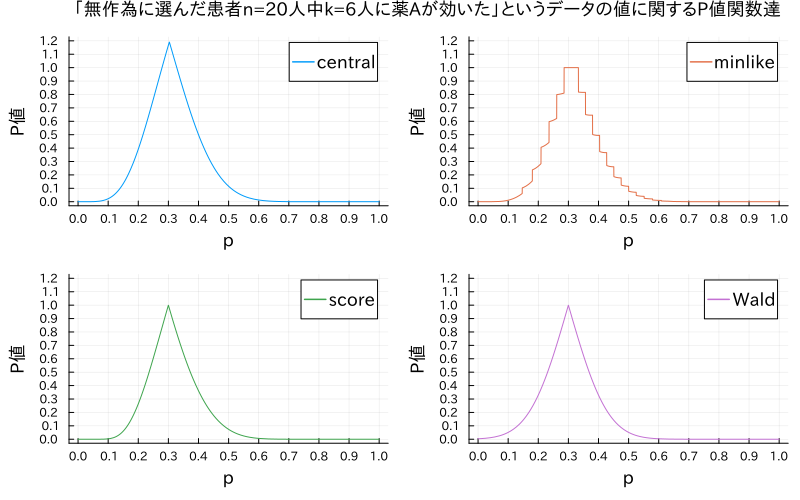

In [32]:
n, k = 20, 6
P1 = plot(p -> pvalue_central(Binomial(n, p), k); label="central", c=1)
P2 = plot(p -> pvalue_minlike(Binomial(n, p), k); label="minlike", c=2)
P3 = plot(p -> pvalue_score(Binomial(n, p), k); label="score", c=3)
P4 = plot(p -> pvalue_wald(Binomial(n, p), k); label="Wald", c=4)
plot(P1, P2, P3, P4; size=(800, 500), layout=(2, 2))
plot!(xtick=0:0.1:1, ytick=0:0.1:1.2, ylim=(-0.03, 1.23))
plot!(xguide="p", yguide="P値")
plot!(plot_title="「無作為に選んだ患者n=$(n)人中k=$(k)人に薬Aが効いた」\
    というデータの値に関するP値関数達")
plot!(leftmargin=4Plots.mm, bottommargin=4Plots.mm)

$n=20$, $k=6$ のような小さなデータでは上のグラフのよう4種のP値関数がかなり異なります。しかし、どれを見ても、$n=20$, $k=6$ のデータの値との相性の良さを表すP値が0より少し大きくなるパラメータ $p$ の範囲はおおむね0.1から0.6の範囲になることがわかります。$n=20$, $k=6$ のような小さなデータではP値関数のグラフの幅は大きくなる。

$n=200$, $k=60$ の場合には以下のように4種のP値関数のグラフの違いは目立たなくなります。上のグラフと比較するとP値関数のグラフの幅が $n=20$, $k=6$ の場合から $n=200$, $k=60$ の場合でおおよそ3分の1程度に狭くなっています。標本サイズを大きくするとP値関数の幅は標本サイズの平方根に反比例して小さくなります。

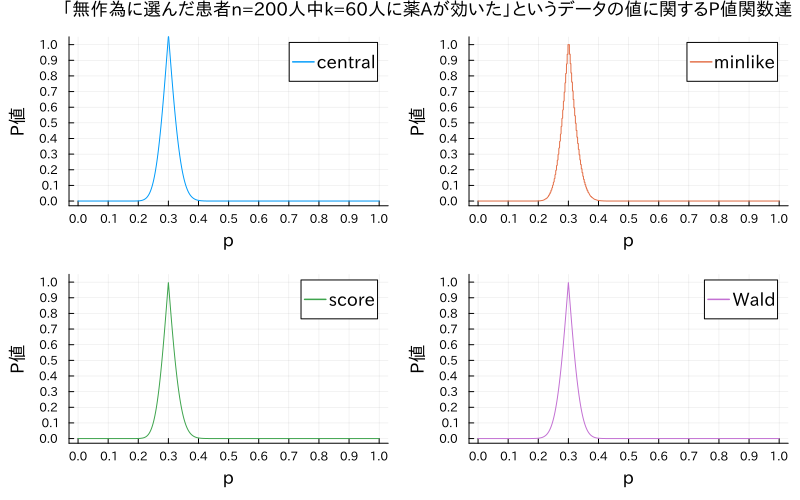

In [33]:
n, k = 200, 60
P1 = plot(p -> pvalue_central(Binomial(n, p), k); label="central", c=1)
P2 = plot(p -> pvalue_minlike(Binomial(n, p), k); label="minlike", c=2)
P3 = plot(p -> pvalue_score(Binomial(n, p), k); label="score", c=3)
P4 = plot(p -> pvalue_wald(Binomial(n, p), k); label="Wald", c=4)
plot(P1, P2, P3, P4; size=(800, 500), layout=(2, 2))
plot!(xtick=0:0.1:1, ytick=0:0.1:1.5, ylim=(-0.03, 1.05))
plot!(xguide="p", yguide="P値")
plot!(plot_title="「無作為に選んだ患者n=$(n)人中k=$(k)人に薬Aが効いた」\
    というデータの値に関するP値関数達")
plot!(leftmargin=4Plots.mm, bottommargin=4Plots.mm)

このグラフを見れば、異なる方法を使っていても、標本サイズが十分に大きいならば、どれを使っても大差ないことが分かります。

## 尤度関数や事後分布とP値関数の比較

この節の内容は self-contained な説明になっていません。しかし、目を通しておけば、後でより進んだ勉強をするときに役に立つと思います。ポイントはP値関数と尤度関数と事後分布の類似性です。たとえ事前分布が偏っていたとしても、それに合わせてP値関数と尤度関数を補正すれば事後分布とほぼ同じ傾向を示すことになります。主義に基く統計学に騙さないように注意して下さい。

In [34]:
"""
「n回中k回成功」というデータの数値が得られたときの
事前分布Beta(a, b)に関する二項分布モデルの事後分布
"""
posterior(n, k; a=1, b=1) = Beta(k+a, n-k+b)

"""
「n回中k回成功」というデータの数値が得られたときの
事前分布Beta(a, b)に関する二項分布モデルの事後分布の密度関数
"""
pdf_posterior(n, k, p; a=1, b=1) = pdf(posterior(n, k; a, b), p)


"""
「n回中k回成功」というデータの数値が得られたときの
二項分布モデルの尤度関数を全積分＝1となるように正規化したもの
"""
likelihood_regularized(n, k, p) = pdf(posterior(n, k; a=1, b=1), p)

likelihood_regularized

この節では以下の4つをグラフで比較する。

* __central P:__ Clopper-Pearsonの相性区間を与えるcentral法のP値関数
* __score P:__ Wilsonのスコア信頼区間を与えるスコア法のP値関数
* __likelihood:__ 全積分＝1で正規化規化された尤度関数
* __posterior:__ ベイズ統計における事後分布の確率密度関数

事前分布が平坦事前分布 $\op{Beta}(a, b)$ の場合の事後分布の確率密度関数は、全積分＝1で正規化された尤度関数は同じものになります。(ただし、パラメータ空間の座標系を変えると座標系に依存して決まる平坦事前分布も変わることに注意して下さい。ある座標系での平坦事前分布が実践的には酷く偏った事前分布になることがあります。)

### データの値が「無作為に選んだ患者 n=20 人中 k=6 人に薬Aが効いた」で、平坦事前分布の場合

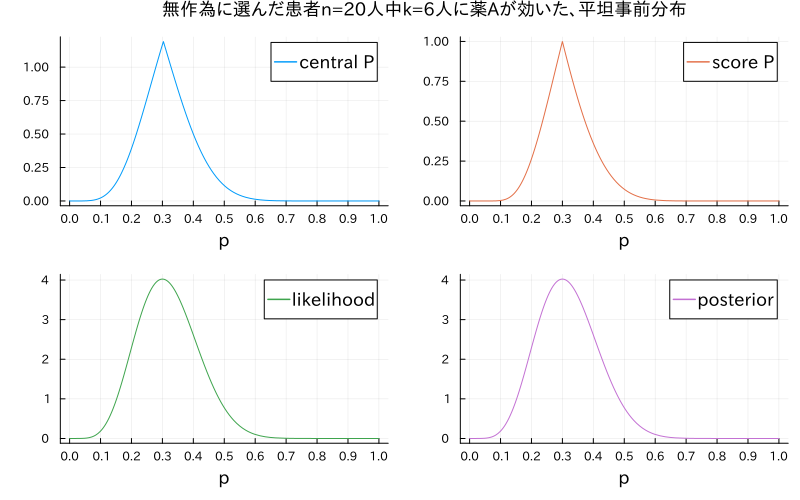

In [35]:
n, k = 20, 6
P1 = plot(p -> pvalue_central(n, k, p), 0, 1; label="central P", c=1)
P2 = plot(p -> pvalue_score(n, k, p), 0, 1; label="score P", c=2)
P3 = plot(p -> likelihood_regularized(n, k, p), 0, 1; label="likelihood", c=3)
P4 = plot(p -> pdf_posterior(n, k, p), 0, 1; label="posterior", c=4)
plot(P1, P2, P3, P4; size=(800, 500), layout=(2, 2))
plot!(xtick=0:0.1:1, xguide="p")
plot!(plot_title="無作為に選んだ患者n=$(n)人中k=$(k)人に薬Aが効いた、平坦事前分布")
plot!(leftmargin=4Plots.mm, bottommargin=4Plots.mm)

平坦事前分布の場合には、正規化された尤度関数と事後分布の密度関数は同じものになり、2種類のP値関数と同じような傾向を示している。

つまり、平坦事前分布の場合には、尤度関数や事後分布はP値関数とほぼ同じ使い方をできる。

### データの値が「無作為に選んだ患者 n=20 人中 k=6 人に薬Aが効いた」で、偏った事前分布の場合

事前分布は $\op{Beta}(5, 2)$ だと仮定する。この事前分布は「事前研究で無作為に選んだ患者 $(5-1)+(2-1)=5$ 人中 $5-1=4$ 人に薬Aが効いた」場合に相当している。

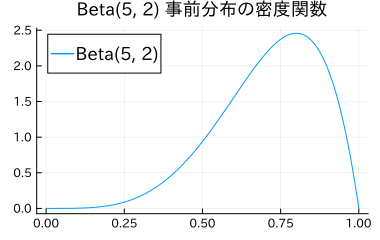

In [36]:
a, b = 5, 2
plot(p -> pdf(Beta(a, b), p), 0, 1; label="Beta($a, $b)", size=(380, 240))
title!("Beta($a, $b) 事前分布の密度関数")

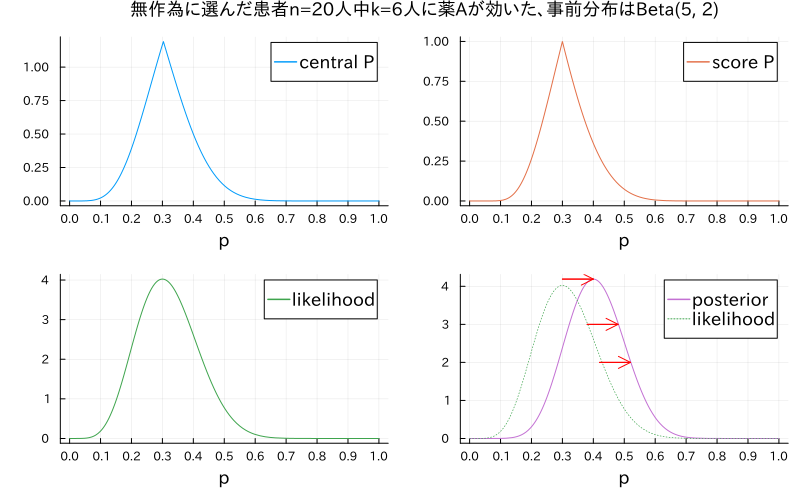

In [37]:
n, k = 20, 6
P1 = plot(p -> pvalue_central(n, k, p), 0, 1; label="central P", c=1)
P2 = plot(p -> pvalue_score(n, k, p), 0, 1; label="score P", c=2)
P3 = plot(p -> likelihood_regularized(n, k, p), 0, 1; label="likelihood", c=3)
post = posterior(n, k; a, b)
P4 = plot(p -> pdf(post, p), 0, 1; label="posterior", c=4)
plot!(p -> likelihood_regularized(n, k, p), 0, 1; label="likelihood", c=3, ls=:dot, lw=0.7)
plot!([0.3, 0.4], fill(pdf(post, mode(post)), 2); label="", arrow=true, c=:red)
plot!([0.38, 0.48], fill(3, 2); label="", arrow=true, c=:red)
plot!([0.42, 0.52], fill(2, 2); label="", arrow=true, c=:red)
plot(P1, P2, P3, P4; size=(800, 500), layout=(2, 2))
plot!(xtick=0:0.1:1, xguide="p")
plot!(plot_title="無作為に選んだ患者n=$(n)人中k=$(k)人に薬Aが効いた、事前分布はBeta($a, $b)")
plot!(leftmargin=4Plots.mm, bottommargin=4Plots.mm)

事前分布が右に偏っていた場合には事後分布は右にシフトします。

上で我々が採用した事前分布は「事前研究で無作為に選んだ患者 $(5-1)+(2-1)=5$ 人中 $5-1=4$ 人に薬Aが効いた」場合に相当しているので、その場合に忠実に対応するP値関数はデータの値を事前研究の場合と合計して得られる「無作為に選んだ患者$n=20+5$人中$k=6+4$人に薬Aが効いた」というデータの値に関するP値関数になります。尤度関数についても同様の補正が考えられます。そのように補正されたP値関数と尤度関数のラベルには "adj." を付けることにします。

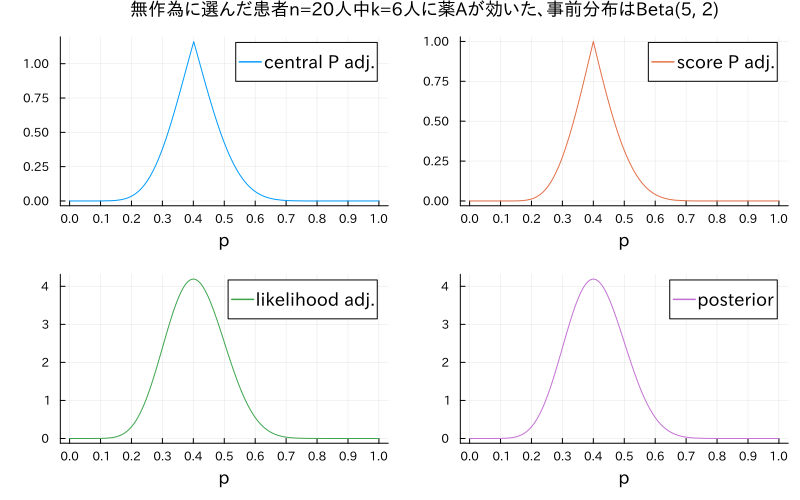

In [38]:
n, k = 20, 6
P1 = plot(p -> pvalue_central(n+a+b-2, k+a-1, p), 0, 1; label="central P adj.", c=1)
P2 = plot(p -> pvalue_score(n+a+b-2, k+a-1, p), 0, 1; label="score P adj.", c=2)
P3 = plot(p -> likelihood_regularized(n+a+b-2, k+a-1, p), 0, 1; label="likelihood adj.", c=3)
post = posterior(n, k; a, b)
P4 = plot(p -> pdf(post, p), 0, 1; label="posterior", c=4)
plot(P1, P2, P3, P4; size=(800, 500), layout=(2, 2))
plot!(xtick=0:0.1:1, xguide="p")
plot!(plot_title="無作為に選んだ患者n=$(n)人中k=$(k)人に薬Aが効いた、事前分布はBeta($a, $b)")
plot!(leftmargin=4Plots.mm, bottommargin=4Plots.mm)

このように事前分布に合わせて補正されたP値関数と尤度関数はベイズ統計の事後分布と同じ傾向を示します。(この場合には事前分布に合わせて補正された正則化された尤度関数は事後分布に一致します。)

### データの値が「無作為に選んだ患者 n=200 人中 k=60 人に薬Aが効いた」で、上と同じ偏った事前分布の場合

事前分布は $\op{Beta}(5, 2)$ だと仮定する。この事前分布は「事前研究で無作為に選んだ患者 $(5-1)+(2-1)=5$ 人中 $5-1=4$ 人に薬Aが効いた」場合に相当している。

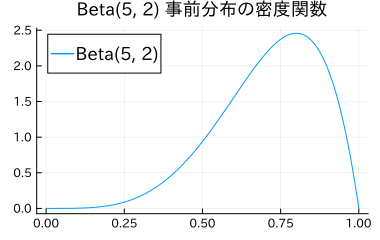

In [39]:
a, b = 5, 2
plot(p -> pdf(Beta(a, b), p), 0, 1; label="Beta($a, $b)", size=(380, 240))
title!("Beta($a, $b) 事前分布の密度関数")

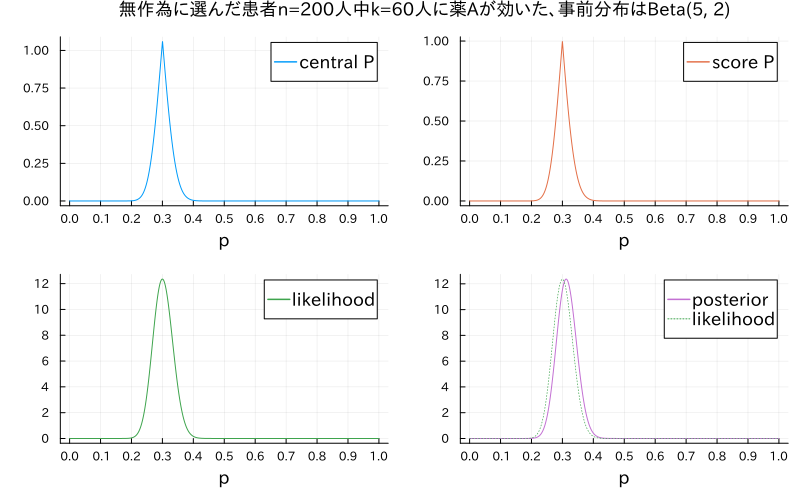

In [40]:
n, k = 200, 60
P1 = plot(p -> pvalue_central(n, k, p), 0, 1; label="central P", c=1)
P2 = plot(p -> pvalue_score(n, k, p), 0, 1; label="score P", c=2)
P3 = plot(p -> likelihood_regularized(n, k, p), 0, 1; label="likelihood", c=3)
post = posterior(n, k; a, b)
P4 = plot(p -> pdf(post, p), 0, 1; label="posterior", c=4)
plot!(p -> likelihood_regularized(n, k, p), 0, 1; label="likelihood", c=3, ls=:dot, lw=0.7)
plot(P1, P2, P3, P4; size=(800, 500), layout=(2, 2))
plot!(xtick=0:0.1:1, xguide="p")
plot!(plot_title="無作為に選んだ患者n=$(n)人中k=$(k)人に薬Aが効いた、事前分布はBeta($a, $b)")
plot!(leftmargin=4Plots.mm, bottommargin=4Plots.mm)

上で我々が採用した事前分布は「事前研究で無作為に選んだ患者 $(5-1)+(2-1)=5$ 人中 $5-1=4$ 人に薬Aが効いた」場合に相当しているのでした。その後新たに「無作為に選んだ患者$n=200$人中$k=60$人に薬Aが効いた」というデータが得られた場合には、新に得られたデータサイズが大きいので、事前分布の影響は小さくなり、事後分布の右へのシフトも小さくなります。

事後分布の偏り具合と比較して、データサイズが十分大きいならば、事前分布の偏りの影響は事後分布にほとんど現れなくなります。

### 比較の結論

* P値関数や尤度関数を使う統計分析と事後分布を使う統計分析は、特に平坦事前分布の場合にはほぼ同じになる。
* 事前分布が偏っている場合であっても、P値関数と尤度関数の側を補正すれば、事後分布を使った場合とほぼ同じ結果を得ることができる。
* データサイズが十分に大きな場合にはそのような補正なしに、P値関数、尤度関数、事後分布はほぼ同じ結果を与える。
* 頻度主義、尤度主義、ベイズ主義のような主義の違いによって全くことなる統計学があるかのように語ることは誤りである。

主義に基く統計学は初学者にとって極めて有害です。初学者は騙されないように注意して下さい。

__注意:__ 以上の結果は二項分布モデルに限らず、シンプルな正則モデルの場合に概ね一般化される。特異モデルの場合には最尤法とベイズ法の間で本質的な違いが生じるので、ベイズ法の側を使用するべきである(\[[渡辺澄夫2012](#渡辺澄夫2012)\]の第4章)。尤度関数によってデータの値を要約する方法(ベイズ統計を含む)も万能ではないことが知られています(\[[Robins-Ritov 1997](#Robins-Ritov-1997)\], \[[Wasserman 2004](#Wasserman-2004)\]の11.9 Example, \[[Ritov et al. 2014](#Ritov-et-al-2014)\])。

## 参照文献

* <a href="Amrhein-Greenland-2022"></a>
\[Amrhein-Greenland 2022\]
[Google Scholar](https://scholar.google.co.jp/scholar?cluster=3720622034719550328)
* <a href="Amrhein-Greenland-McShane-2019"></a>
\[Amrhein-Greenland-McShane 2019\]
[Google Scholar](https://scholar.google.co.jp/scholar?cluster=10149294426414499676)
* <a name="ASA声明2016"></a>
\[ASA声明2016\]
[Google Scholar](https://scholar.google.co.jp/scholar?cluster=9276800766809907647)
\[[日本語訳](https://www.biometrics.gr.jp/news/all/ASA.pdf)\]
* <a name="Agresti-Coull-1998"></a>
\[Agresti-Coull 1998\]
[Google Scholar](https://scholar.google.co.jp/scholar?cluster=5129299358902170657)
* <a name="Clopper-Pearson-1934"></a>
\[Clopper-Pearson 1934\]
[Google Scholar](https://scholar.google.co.jp/scholar?cluster=14961616766983395623)
* <a name="Gelman-Greenland-2019"></a>
\[Gelman-Greenland 2019\]
[Google Scholar](https://scholar.google.co.jp/scholar?cluster=9083230676635824516)
* <a name="Gelman-Vehtari-2024"></a>
\[Gelman-Vehtari 2024\]
[Web site](https://avehtari.github.io/ActiveStatistics/)
\[[教訓要約](https://gist.github.com/genkuroki/2d8909d56aeaa58747dcef962787edfd)\]
\[[教訓集1](https://gist.github.com/genkuroki/b7361449de6bacf786e867a74e0e391a)\]
\[[教訓集2](https://gist.github.com/genkuroki/e8a1bc4791bc2f8a36737e80474fd800)\]
* <a name="Greenland-slide-2022"></a>
\[Greenland slide 2022\]
\[[PDF](https://biostatistics.ucdavis.edu/sites/g/files/dgvnsk4966/files/media/documents/Greenland.Advancing%20statistics%20reform%2C%20part%204.Slides%201-110%2C%2001%20June%202022.pdf)\]
\[[日本語版](https://github.com/genkuroki/public/blob/main/0055/GreenlandSlide2022JapaneseTranslation/%E7%B5%B1%E8%A8%88%E5%AD%A6%E6%94%B9%E9%9D%A9%E3%81%AE%E6%8E%A8%E9%80%B2%EF%BC%9A%E6%8A%B5%E6%8A%97%E3%81%AB%E7%9B%B4%E9%9D%A2%E3%81%97%E3%81%9F%E9%9A%9B%E3%81%AE%E6%80%9D%E8%80%83%E3%81%A8%E5%AE%9F%E8%B7%B5%E3%82%92%E6%94%B9%E5%96%84%E3%81%99%E3%82%8B%E6%96%B9%E6%B3%95.ipynb)\]
* <a name="Greenland-et-al-2016"></a>
\[Greenland et al. 2016\]
[Google Scholar](https://scholar.google.co.jp/scholar?cluster=3941075655195102850)
* <a name="Lusinchi-2012"></a>
\[Lusinchi 2012\]
[Google Scholar](https://scholar.google.co.jp/scholar?cluster=5805358583625636408)
\[[動画解説](#video-Lusinchi-2012)\]
\[[PDF](https://www.researchgate.net/profile/Dominic-Lusinchi/publication/241900337_President_Landon_and_the_1936_Literary_Digest_Poll_Were_Automobile_and_Telephone_Owners_to_Blame/links/5f14a169a6fdcc3ed715c1da/President-Landon-and-the-1936-Literary-Digest-Poll-Were-Automobile-and-Telephone-Owners-to-Blame.pdf)\]
* <a name="Lohr-Brick-2017"></a>
\[Lohr-Brick 2017\]
[Google Scholar](https://scholar.google.co.jp/scholar?cluster=16516556830512819097)
\[[動画解説](#video-Lohr-Brick-2017)\]
\[[PDF](https://gwern.net/doc/statistics/bias/2017-lohr.pdf)\]
* <a name="McShane-et-al-2024"></a>
\[McShane et al. 2024\]
[Google Scholar](https://scholar.google.co.jp/scholar?cluster=17720116793246961868)
\[[動画解説1](#video-McShane-et-al-2024-1)\]
\[[動画解説2](#video-McShane-et-al-2024-2)\]
\[[統計分析の報告に関するガイドラインの日本語版](https://gist.github.com/genkuroki/a7fa24c7b446b3eb267b03b1dc7959c1)\]
* <a href="McShane-Gelman-2022"></a>
\[McShane-Gelman 2022\]
[Google Scholar](https://scholar.google.co.jp/scholar?cluster=9139328184649122630)
* <a name="中原治2022"></a>
\[中原治2022\]
[Web site](https://www.yodosha.co.jp/yodobook/book/9784758121217/)
* <a name="Rafi-Greenland-2020"></a>
\[Rafi-Greenland 2020\]
[Google Scholar](https://scholar.google.co.jp/scholar?cluster=591718439647960929)
* <a name="Ritov-et-al-2014"></a>
\[Ritov et al. 2014\] [Google Scholar](https://scholar.google.co.jp/scholar?cluster=11322335852337441582)
* <a name="Robins-Ritov-1997"></a>
\[Robins-Ritov 1997\] [--Google Scholar](https://scholar.google.co.jp/scholar?cluster=12152158785509725164)
* <a name="ロスマンの疫学2013"></a>
\[ロスマンの疫学2013\]
[Web site](https://shinoharashinsha.co.jp/?page_id=3534)
* <a name="佐藤俊哉2024"></a>
\[佐藤俊哉2024\]
[Web site](https://www.asakura.co.jp/detail.php?book_code=12297)
* <a name="Sterne-1954"></a>
\[Sterne 1954\]
[Google Scholar](https://scholar.google.co.jp/scholar?cluster=18420119515180283098)
* <a name="Wald-1939"></a>
\[Wald 1939\]
[Google Scholar](https://scholar.google.co.jp/scholar?cluster=1375947589172221492)
* <a name="Wasserman-2004"></a>
\[Wasserman 2004\] [Google search](https://www.google.com/search?q=Wasserman+%E2%80%9DAll+of+Statistics%22+%222004%22)
\[[PDF](https://www.stat.cmu.edu/~brian/valerie/617-2022/0%20-%20books/2004%20-%20wasserman%20-%20all%20of%20statistics.pdf)\]
\[[11.9の例の簡単な紹介](#example-Wasserman-2014)\]
* <a name="渡辺澄夫2012"></a>
\[渡辺澄夫2012\] [Web site](https://www.coronasha.co.jp/np/isbn/9784339024623/)
* <a name="Wilson-1927"></a>
\[Wilson 1927\]
[Google Scholar](https://scholar.google.co.jp/scholar?cluster=9907942007440998358)

## 動画解説

🔴 <a name="video-Lusinchi-2012"></a>\[[Lusinchi 2012](#Lusinchi-2012)\]の動画解説

* https://github.com/genkuroki/public/raw/refs/heads/main/0055/Lusinchi-2012.mp4

<video width=500 controls src="https://github.com/genkuroki/public/raw/refs/heads/main/0055/Lusinchi-2012.mp4"></video>

🔴 <a name="video-Lohr-Brick-2017"></a>\[[Lohr-Brick 2017](#Lohr-Brick-2017)\]の動画解説

* https://github.com/genkuroki/public/raw/refs/heads/main/0055/Lohr-Brick-2017.mp4

<video width=500 controls src="https://github.com/genkuroki/public/raw/refs/heads/main/0055/Lohr-Brick-2017.mp4"></video>

🔴 <a name="video-McShane-et-al-2024-1"></a>\[[McShane et al. 2024](#McShane-et-al-2024)\]の動画解説1

* https://github.com/genkuroki/public/raw/refs/heads/main/0055/McShane-et-al-2024-1.mp4

<video width=500 controls src="https://github.com/genkuroki/public/raw/refs/heads/main/0055/McShane-et-al-2024-1.mp4"></video>

🔴 <a name="video-McShane-et-al-2024-1"></a>\[[McShane et al. 2024](#McShane-et-al-2024)\]の動画解説2

* https://github.com/genkuroki/public/raw/refs/heads/main/0055/McShane-et-al-2024-2.mp4

<video width=500 controls src="https://github.com/genkuroki/public/raw/refs/heads/main/0055/McShane-et-al-2024-2.mp4"></video>

## Wasserman 2014の11.9の例の簡単な紹介

<a name="example-Wasserman-2014"></a>\[[Wasserman 2004](#Wasserman-2004)\]の11.9 Exampleを簡単に紹介しよう。

<img width=700 src="https://raw.githubusercontent.com/genkuroki/public/refs/heads/main/0055/Wasserman-2014.jpg">